# Libraries

In [561]:
import pandas as pd
import numpy as np
from scipy.interpolate import make_interp_spline

from astroquery.gaia import Gaia

from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore', category=UserWarning)


# Plot parametres

In [97]:
plt.rcParams.update({
    'figure.figsize': (8, 6),  # Размеры графиков
    'figure.dpi': 100,  # Разрешение графиков
    'savefig.dpi': 300,  # Разрешение сохраненных изображений
    'font.size': 12,  # Размер шрифта
    'font.family': 'serif',  # Семейство шрифтов
    'axes.labelsize': 14,  # Размер шрифта для подписей осей
    'axes.titlesize': 14,  # Размер шрифта для заголовков
    'xtick.labelsize': 12,  # Размер шрифта для подписей меток на оси X
    'ytick.labelsize': 12,  # Размер шрифта для подписей меток на оси Y
    'legend.fontsize': 10,  # Размер шрифта для легенды
    'lines.linewidth': 1,  # Толщина линий
    'lines.markersize': 6,  # Размер маркеров
    'axes.grid': False,  # Сетка на графиках
    'grid.alpha': 0.25,  # Прозрачность сетки
    'grid.linestyle': '--',  # Стиль линии сетки
    'grid.color': 'gray',  # Цвет сетки
    'axes.axisbelow': True,  # Сетка ниже данных
    'image.cmap': 'viridis',  # Цветовая карта для изображений
    'errorbar.capsize': 3,  # Размер "колпачков" на графиках ошибок
    "legend.loc": 'best', 
})

# Load catalogue

In [99]:
cat = fits.open("output/variable_star_crossmatch/catalogue_founded_varstar.fits")

In [100]:
cat[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 3860 / length of dimension 1                          
NAXIS2  =                20961 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                   59 / number of table fields                         
TTYPE1  = 'Star NAME'                                                           
TFORM1  = '10A     '                                                            
TTYPE2  = 'NAME    '                                                            
TFORM2  = '10A     '                                                            
TTYPE3  = 'RA      '        

In [101]:
df = pd.DataFrame(cat[1].data)

In [102]:
df = df.applymap(lambda x: None if isinstance(x, str) and x.strip() == "" else x)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20961 entries, 0 to 20960
Data columns (total 59 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Star NAME               20961 non-null  object 
 1   NAME                    20961 non-null  object 
 2   RA                      20961 non-null  float64
 3   DEC                     20961 non-null  float64
 4   SPECT_TYPE              5966 non-null   object 
 5   MIN_MAG_LIMIT           2837 non-null   object 
 6   MIN_MAG                 20961 non-null  float64
 7   MAX_MAG_LIMIT           0 non-null      object 
 8   MAX_MAG                 20961 non-null  float64
 9   VARIABILITY_TYPE        20640 non-null  object 
 10  PERIOD_LIMIT            53 non-null     object 
 11  PERIOD                  20961 non-null  float64
 12  PERIOD_FLAG             929 non-null    object 
 13  VARIABLE_STAR_NUMBER    20961 non-null  int64  
 14  VARIABLE_STAR_CPT       13 non-null   

/var/folders/kv/prhthx396zd4k1d7f55bdztc0000gn/T/ipykernel_14473/1970863562.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: None if isinstance(x, str) and x.strip() == "" else x)


# Analysis

## Period

### Data

In [109]:
# Создание нового столбца с полным значением периода, учитывая точность из PERIOD_PRECISION
def calculate_full_period(row):
    # Проверка наличия значений в столбцах PERIOD и PERIOD_PRECISION
    if not np.isnan(row['PERIOD']) and not np.isnan(row['PERIOD_PRECISION']):
        # Определение количества знаков после запятой
        precision = int(row['PERIOD_PRECISION'])
        # Форматирование периода с учетом заданной точности
        return f"{row['PERIOD']:.{precision}f}"
    else:
        return None

# Применение функции к каждой строке и создание нового столбца 'FULL_PERIOD'
df['FULL_PERIOD'] = df.apply(calculate_full_period, axis=1)

df['FULL_PERIOD'] = df['FULL_PERIOD'].apply(lambda x: None if x == 0 or x == "0" else x).astype("float64")

### Plot

/var/folders/kv/prhthx396zd4k1d7f55bdztc0000gn/T/ipykernel_14473/1296311494.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


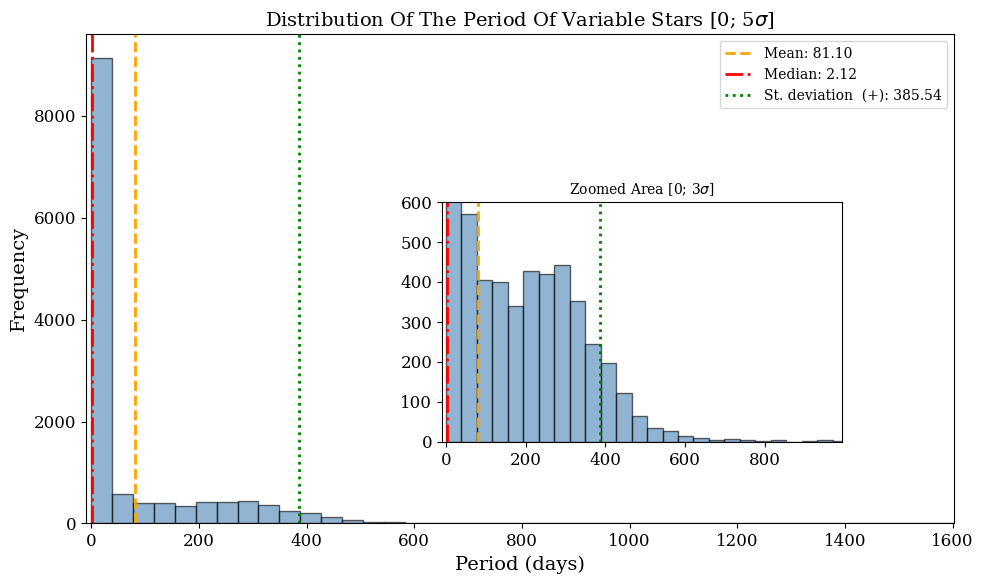

In [111]:
full_period_data = df['FULL_PERIOD'].dropna()

# Основные статистические данные
mean_period = full_period_data.mean()
median_period = full_period_data.median()
std_dev_period = full_period_data.std()

# Построение гистограммы с полным распределением и увеличенным вложенным графиком в правом верхнем углу

plt.figure(figsize=(10, 6))
# Полный график
plt.hist(full_period_data, bins=650, color="steelblue", edgecolor="black", alpha=0.6)
plt.axvline(mean_period, color='orange', linestyle='--', lw=2, label=f'Mean: {mean_period:.2f}')
plt.axvline(median_period, color='red', linestyle='-.', lw=2, label=f'Median: {median_period:.2f}')
plt.axvline(mean_period + std_dev_period, color='green', linestyle=':', lw=2, label=f'St. deviation  (+): {mean_period + std_dev_period:.2f}')
plt.legend()
plt.title('Distribution Of The Period Of Variable Stars [0; 5$\sigma$]')
plt.xlabel('Period (days)')
plt.ylabel('Frequency')
plt.xlim(-10, mean_period + std_dev_period * 5)

# Вложенный график (увеличенная область)
inset_ax = plt.axes([0.45, 0.25, 0.4, 0.4])  # положение и размер вложенного графика
inset_ax.hist(full_period_data, bins=650, color="steelblue", edgecolor="black", alpha=0.6)
inset_ax.axvline(mean_period, color='orange', linestyle='--', lw=2 )
inset_ax.axvline(median_period, color='red', linestyle='-.', lw=2)
inset_ax.axvline(mean_period + std_dev_period, color='green', linestyle=':', lw=2)
inset_ax.set_xlim(-10, mean_period + std_dev_period*3)
inset_ax.set_ylim(0, 600)
inset_ax.set_title(rf'Zoomed Area [0; 3$\sigma$]', fontsize=10)

plt.tight_layout()
plt.savefig("output/variable_star_crossmatch/period_distrib.png", dpi=300)
plt.show()


## Magnitude

### Data

In [114]:
# Фильтрация данных MIN_MAG и MAX_MAG с учетом флага "("
filtered_min_mag_data = df.loc[df['MIN_MAG_LIMIT'] != '(', 'MIN_MAG'].dropna()
filtered_max_mag_data = df.loc[df['MAX_MAG_LIMIT'] != '(', 'MAX_MAG'].dropna()

# Основные статистические данные для отфильтрованных данных MIN_MAG
mean_min_mag_filtered = filtered_min_mag_data.mean()
median_min_mag_filtered = filtered_min_mag_data.median()
std_dev_min_mag_filtered = filtered_min_mag_data.std()

# Основные статистические данные для отфильтрованных данных MAX_MAG
mean_max_mag_filtered = filtered_max_mag_data.mean()
median_max_mag_filtered = filtered_max_mag_data.median()
std_dev_max_mag_filtered = filtered_max_mag_data.std()

### Plot

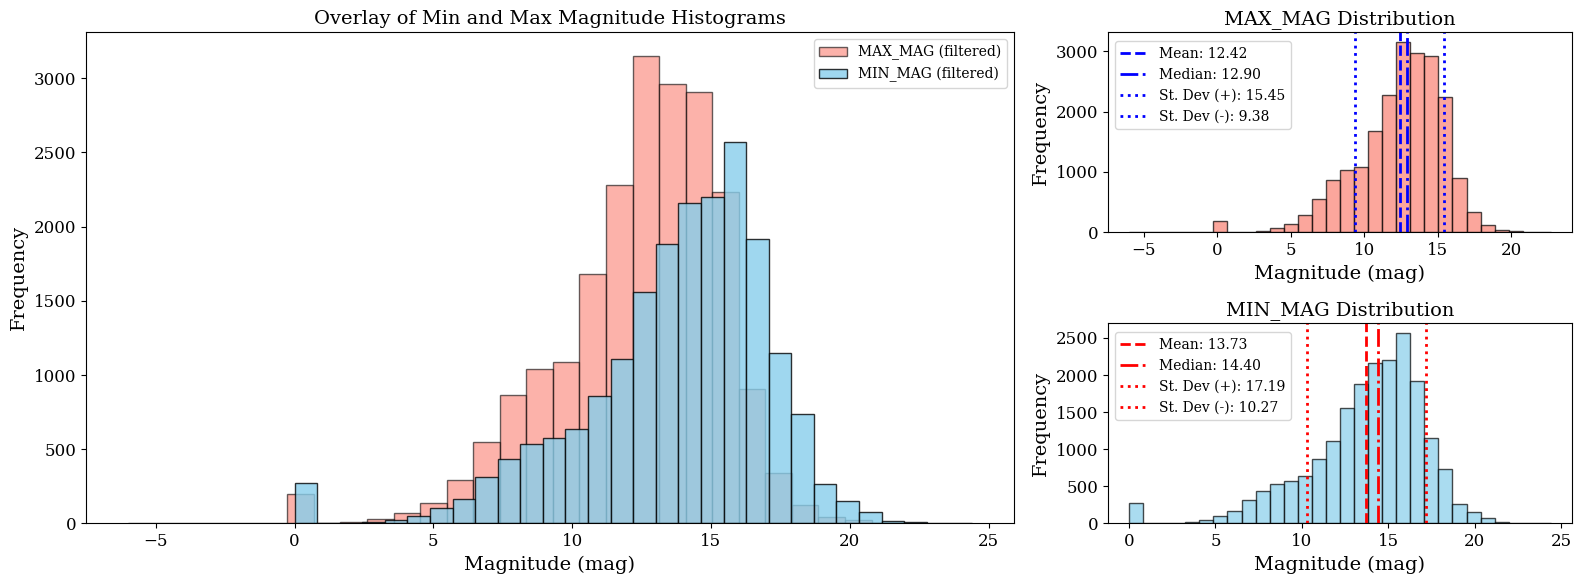

In [116]:
# Creating figure with main histogram and two vertical subplots
fig = plt.figure(figsize=(16,6))
gs = fig.add_gridspec(2, 2, width_ratios=[2, 1], height_ratios=[1, 1])

# Main overlayed histogram for MAX_MAG and MIN_MAG
ax_main = fig.add_subplot(gs[:, 0])
ax_main.hist(filtered_max_mag_data, bins=30, color="salmon", edgecolor="black", alpha=0.6, label='MAX_MAG (filtered)')
ax_main.hist(filtered_min_mag_data, bins=30, color="skyblue", edgecolor="black", alpha=0.8, label='MIN_MAG (filtered)')
ax_main.set_title('Overlay of Min and Max Magnitude Histograms')
ax_main.set_xlabel('Magnitude (mag)')
ax_main.set_ylabel('Frequency')
ax_main.legend()

# MAX_MAG Distribution with statistical lines
ax_max_mag = fig.add_subplot(gs[0, 1])
ax_max_mag.hist(filtered_max_mag_data, bins=30, color="salmon", edgecolor="black", alpha=0.7)
ax_max_mag.axvline(mean_max_mag_filtered, color='blue', linestyle='--', lw=2, label=f'Mean: {mean_max_mag_filtered:.2f}')
ax_max_mag.axvline(median_max_mag_filtered, color='blue', linestyle='-.', lw=2, label=f'Median: {median_max_mag_filtered:.2f}')
ax_max_mag.axvline(mean_max_mag_filtered + std_dev_max_mag_filtered, color='blue', linestyle=':', lw=2, label=f'St. Dev (+): {mean_max_mag_filtered + std_dev_max_mag_filtered:.2f}')
ax_max_mag.axvline(mean_max_mag_filtered - std_dev_max_mag_filtered, color='blue', linestyle=':', lw=2, label=f'St. Dev (-): {mean_max_mag_filtered - std_dev_max_mag_filtered:.2f}')
ax_max_mag.set_title('MAX_MAG Distribution')
ax_max_mag.set_xlabel('Magnitude (mag)')
ax_max_mag.set_ylabel('Frequency')
ax_max_mag.legend(bbox_to_anchor=(0, 0., 0.7, 0.99))

# MIN_MAG Distribution with statistical lines
ax_min_mag = fig.add_subplot(gs[1, 1])
ax_min_mag.hist(filtered_min_mag_data, bins=30, color="skyblue", edgecolor="black", alpha=0.7)
ax_min_mag.axvline(mean_min_mag_filtered, color='red', linestyle='--', lw=2, label=f'Mean: {mean_min_mag_filtered:.2f}')
ax_min_mag.axvline(median_min_mag_filtered, color='red', linestyle='-.', lw=2, label=f'Median: {median_min_mag_filtered:.2f}')
ax_min_mag.axvline(mean_min_mag_filtered + std_dev_min_mag_filtered, color='red', linestyle=':', lw=2, label=f'St. Dev (+): {mean_min_mag_filtered + std_dev_min_mag_filtered:.2f}')
ax_min_mag.axvline(mean_min_mag_filtered - std_dev_min_mag_filtered, color='red', linestyle=':', lw=2, label=f'St. Dev (-): {mean_min_mag_filtered - std_dev_min_mag_filtered:.2f}')
ax_min_mag.set_title('MIN_MAG Distribution')
ax_min_mag.set_xlabel('Magnitude (mag)')
ax_min_mag.set_ylabel('Frequency')
ax_min_mag.legend(bbox_to_anchor=(0, 0., 0.7, 0.99))

# Adjust layout and display
plt.tight_layout()
plt.savefig("output/variable_star_crossmatch/mag_min_max_distrib.png", dpi=300)
plt.show()

## Amplitude

### Data

In [119]:
# Вычисление амплитуды, учитывая условия на MIN_MAG_LIMIT и MAX_MAG_LIMIT
df['Amplitude'] = df.apply(
    lambda row: row['MAX_MAG'] - row['MIN_MAG'] if row['MIN_MAG_LIMIT'] != '(' and row['MAX_MAG_LIMIT'] != '(' else None,
    axis=1
)

# Удаление NaN значений из столбца амплитуды для построения гистограммы
amplitude_data = df['Amplitude'].dropna()
amplitude_data = abs(amplitude_data)

# Основные статистические данные для амплитуды
mean_amplitude = amplitude_data.mean()
median_amplitude = amplitude_data.median()
std_dev_amplitude = amplitude_data.std()

### Plot

/var/folders/kv/prhthx396zd4k1d7f55bdztc0000gn/T/ipykernel_14473/91655739.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


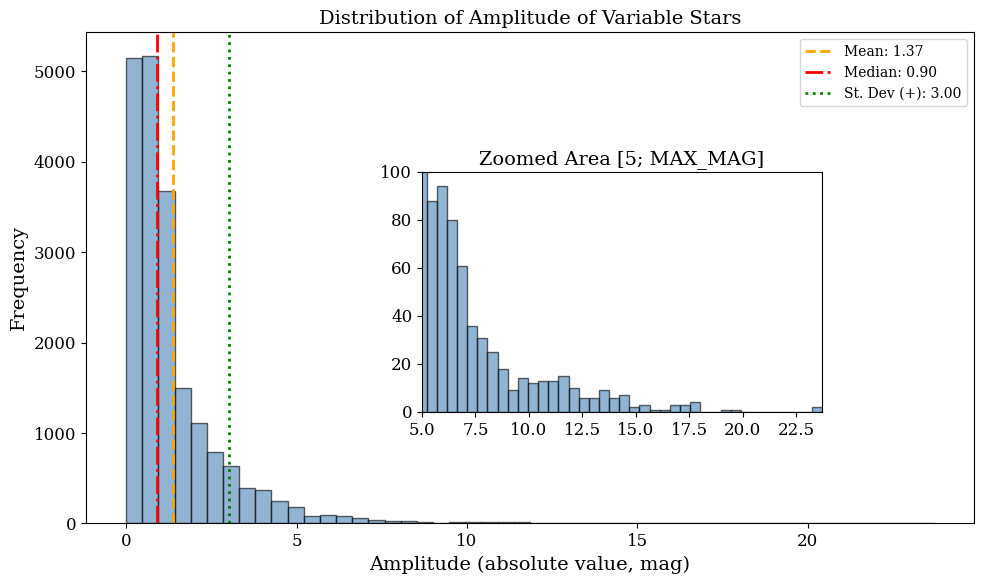

In [121]:
# Построение основной гистограммы
fig, ax_main = plt.subplots(figsize=(10, 6))
ax_main.hist(amplitude_data, bins=50, color="steelblue", edgecolor="black", alpha=0.6)

# Добавление линий для основных статистик
ax_main.axvline(mean_amplitude, color='orange', linestyle='--', lw=2, label=f'Mean: {mean_amplitude:.2f}')
ax_main.axvline(median_amplitude, color='red', linestyle='-.', lw=2, label=f'Median: {median_amplitude:.2f}')
ax_main.axvline(mean_amplitude + std_dev_amplitude, color='green', linestyle=':', lw=2, label=f'St. Dev (+): {mean_amplitude + std_dev_amplitude:.2f}')

# Настройка основной гистограммы
ax_main.legend()
ax_main.set_title('Distribution of Amplitude of Variable Stars')
ax_main.set_xlabel('Amplitude (absolute value, mag)')
ax_main.set_ylabel('Frequency')

# Добавление увеличенного вложенного графика
ax_inset = fig.add_axes([0.43, 0.3, 0.4, 0.4])  # [left, bottom, width, height] для положения и размера
ax_inset.hist(amplitude_data, bins=50, color="steelblue", edgecolor="black", alpha=0.6)
ax_inset.set_xlim(5, max(amplitude_data))  # Установка лимитов для оси X
ax_inset.set_xticks([5,7.5,10,12.5,15,17.5,20,22.5])
ax_inset.set_ylim(0, 100)  # Установка лимитов для оси Y
ax_inset.set_title('Zoomed Area [5; MAX_MAG]')
ax_inset.axvline(mean_amplitude, color='red', linestyle='--', lw=1)
ax_inset.axvline(median_amplitude, color='green', linestyle='-.', lw=1)
ax_inset.axvline(mean_amplitude + std_dev_amplitude, color='purple', linestyle=':', lw=1)

plt.tight_layout()
plt.savefig("output/variable_star_crossmatch/mag_amplitude_distrib.png", dpi=300)

plt.show()

## Proper motion

### Data

In [126]:
# Вычисление результирующего собственного движения
df['PM_total'] = np.sqrt(df['PM_RA']**2 + df['PM_DEC']**2)
# Удаление NaN значений из столбца PM_total для построения гистограммы
pm_total_data = df['PM_total'].dropna()
# Основные статистические данные для PM_total
mean_pm_total = pm_total_data.mean()
median_pm_total = pm_total_data.median()
std_dev_pm_total = pm_total_data.std()

### Plot

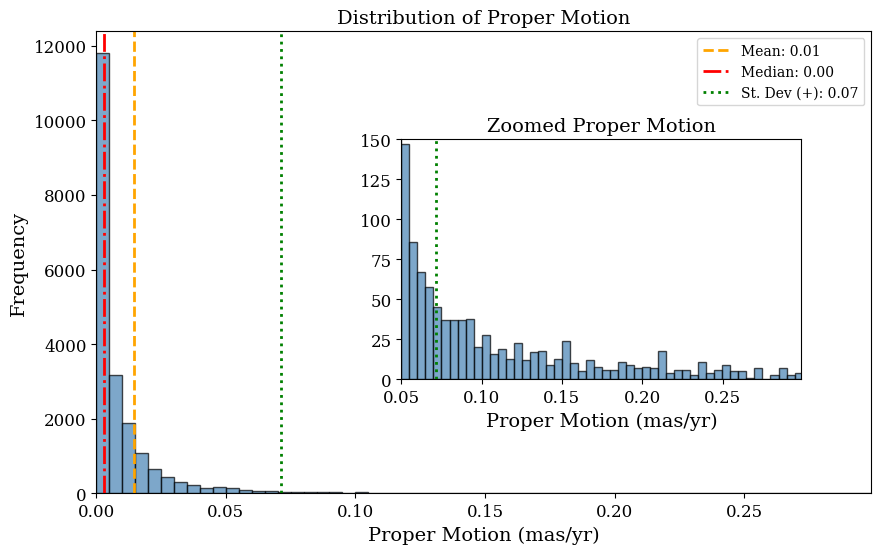

In [128]:
# Построение гистограммы PM_total с дополнительным увеличенным графиком
fig, main_ax = plt.subplots(figsize=(10, 6))

# Основной график гистограммы
main_ax.hist(pm_total_data, bins=650, color="steelblue", edgecolor="black", alpha=0.7)
main_ax.set_title('Distribution of Proper Motion')
main_ax.set_xlabel('Proper Motion (mas/yr)')
main_ax.set_ylabel('Frequency')
main_ax.set_xlim(0, mean_pm_total + std_dev_pm_total*5)

# Добавление линий для основных статистик на основном графике
main_ax.axvline(mean_pm_total, color='orange', linestyle='--', lw=2, label=f'Mean: {mean_pm_total:.2f}')
main_ax.axvline(median_pm_total, color='red', linestyle='-.', lw=2, label=f'Median: {median_pm_total:.2f}')
main_ax.axvline(mean_pm_total + std_dev_pm_total, color='green', linestyle=':', lw=2, label=f'St. Dev (+): {mean_pm_total + std_dev_pm_total:.2f}')

# Настройка легенды на основном графике
main_ax.legend()

inset_ax = fig.add_axes([0.43, 0.3, 0.4, 0.4])  # [left, bottom, width, height] для положения и размера
# Вставка увеличенного графика справа
inset_ax.hist(pm_total_data, bins=650, color="steelblue", edgecolor="black", alpha=0.7)
inset_ax.set_xlim(0.05, mean_pm_total + std_dev_pm_total*5)
inset_ax.set_ylim(0, 150)
inset_ax.set_title('Zoomed Proper Motion')
inset_ax.set_xlabel('Proper Motion (mas/yr)')

# Добавление линий для основных статистик на вставленном графике
inset_ax.axvline(mean_pm_total, color='orange', linestyle='--', lw=2)
inset_ax.axvline(median_pm_total, color='red', linestyle='-.', lw=2)
inset_ax.axvline(mean_pm_total + std_dev_pm_total, color='green', linestyle=':', lw=2)

#plt.tight_layout()
plt.savefig("output/variable_star_crossmatch/proper_motion_distrib.png", dpi=300)
plt.show()


## Aitoff destribution

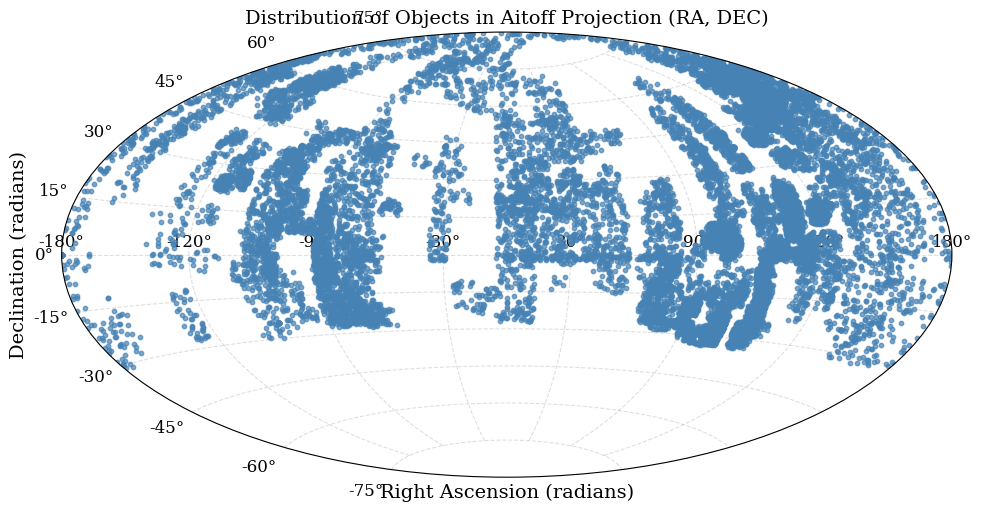

In [130]:
# Преобразование координат из градусов в радианы для Aitoff проекции
# Преобразуем RA из диапазона [0, 360] в [-π, π] (центрирование вокруг 0)
df['RA_rad'] = np.radians(df['RA'] - 180)
df['DEC_rad'] = np.radians(df['DEC'])

# Создание фигуры и оси с проекцией Aitoff
plt.figure(figsize=(10, 6))
ax = plt.subplot(111, projection="aitoff")
ax.grid(True)

# Построение точек на графике
ax.scatter(df['RA_rad'], df['DEC_rad'], s=10, color='steelblue', alpha=0.7, marker='o')

# Настройка xticks для отображения RA
xticks = np.linspace(-np.pi, np.pi, 8)

ax.set_xticks(xticks)

# Опускание xtick меток на 45 единиц вниз по вертикали
for label in ax.get_xticklabels():
    label.set_y(-0.45)  # опускание на 45 единиц по вертикали


# Настройка подписей
plt.title("Distribution of Objects in Aitoff Projection (RA, DEC)")
plt.xlabel("Right Ascension (radians)")
plt.ylabel("Declination (radians)")
plt.tight_layout()
# Показ графика
plt.show()

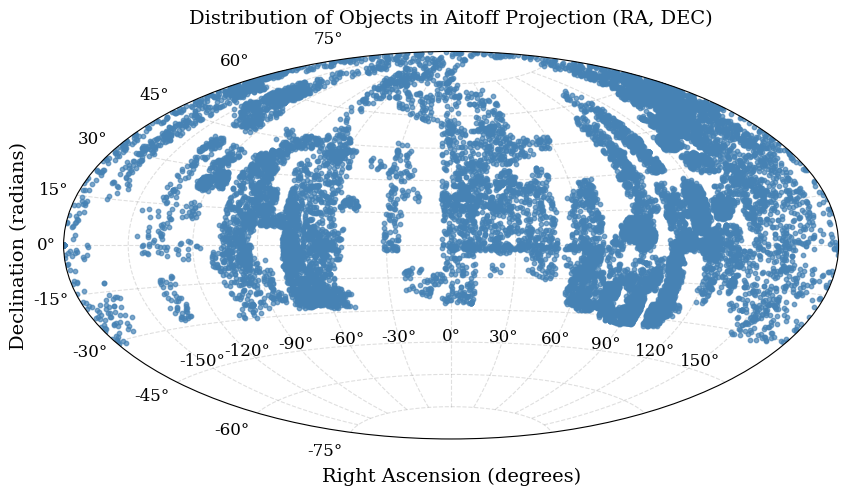

In [131]:
# Преобразование координат из градусов в радианы для Aitoff проекции
df['RA_rad'] = np.radians(df['RA'] - 180)  # центрирование вокруг 0°
df['DEC_rad'] = np.radians(df['DEC'])

# Создание фигуры и оси с проекцией Aitoff
plt.figure(figsize=(10, 6))
ax = plt.subplot(111, projection="aitoff")
ax.grid(True)

# Построение точек на графике
ax.scatter(df['RA_rad'], df['DEC_rad'], s=10, color='steelblue', alpha=0.7, marker='o')

# Custom ticks for RA degrees, placed at Dec = -42 degrees
ra_labels = np.arange(-180, 181, 30)  # RA labels from -180° to 180° with шаг 30°
for ra in ra_labels:
    if ra != -180 and ra != 180:  # Пропускаем метки для -180° и 180°
      ax.text(np.deg2rad(ra), np.deg2rad(-42), f'{ra}°', ha='center', va='center')  # RA labels at -42°
# Disable default ticks at 0° but keep vertical lines (grid)

# Удаление стандартных меток оси X для RA
ax.set_xticklabels([])

# Настройка подписей
plt.title("Distribution of Objects in Aitoff Projection (RA, DEC)", pad=20)
plt.xlabel("Right Ascension (degrees)", labelpad=20)
plt.ylabel("Declination (radians)")

# Показ графика
plt.show()


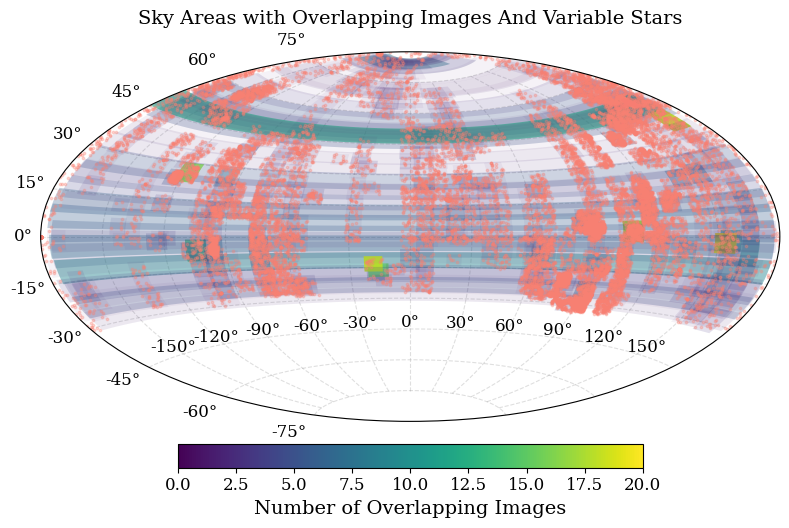

In [132]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Function to parse the data file and extract coordinates
def parse_sky_area_data(filename):
    areas = []
    with open(filename, 'r') as file:
        lines = file.readlines()
        
        current_area = {}
        for line in lines:
            line = line.strip()
            if line.startswith("Area"):
                if current_area:
                    areas.append(current_area)
                current_area = {}
            elif "RA:" in line:
                ra_values = line.split(":")[1].strip().split(" - ")
                current_area['ra_min'] = float(ra_values[0])
                current_area['ra_max'] = float(ra_values[1])
            elif "Dec:" in line:
                dec_values = line.split(":")[1].strip().split(" - ")
                current_area['dec_min'] = float(dec_values[0])
                current_area['dec_max'] = float(dec_values[1])
            elif "Number of Overlapping Images:" in line:
                current_area['overlaps'] = int(line.split(":")[1].strip())
        
        if current_area:
            areas.append(current_area)
    
    return areas

# Function to plot the data on an Aitoff projection
def plot_sky_areas_aitoff(areas,df):
    plt.figure(figsize=(12, 6))
    ax = plt.subplot(111, projection="aitoff")
    ax.grid(True)
    
    max_overlaps = max(area['overlaps'] for area in areas)
    
    for area in areas:
        ra_min_radians = np.radians(area['ra_min'] - 180)
        ra_max_radians = np.radians(area['ra_max'] - 180)
        dec_min_radians = np.radians(area['dec_min'])
        dec_max_radians = np.radians(area['dec_max'])
        
        # Define rectangle properties
        alpha = area['overlaps'] / max_overlaps  # Transparency based on overlap count
        color = plt.cm.viridis(alpha)  # Use viridis colormap
        
        # Adjust rectangle to match Aitoff projection
        rect = patches.Rectangle(
            (ra_min_radians, dec_min_radians),
            ra_max_radians - ra_min_radians,
            dec_max_radians - dec_min_radians,
            color=color,
            alpha=alpha,
            linewidth=0
        )
        ax.add_patch(rect)
    
    # Color bar to show the scale of overlaps
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=max_overlaps))
    sm.set_array([])
    # Explicitly set colorbar to the Aitoff axis
    cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', pad=0.05, shrink=0.5)
    cbar.set_label('Number of Overlapping Images')
    plt.scatter(df['RA_rad'], df['DEC_rad'], s=3, color='salmon', alpha=0.3, marker='o')
    # Custom ticks for RA degrees, placed at Dec = -42 degrees
    ra_labels = np.arange(-180, 181, 30)  # RA labels from -180° to 180° with шаг 30°
    for ra in ra_labels:
        if ra != -180 and ra != 180:  # Пропускаем метки для -180° и 180°
            plt.text(np.deg2rad(ra), np.deg2rad(-42), f'{ra}°', ha='center', va='center')  # RA labels at -42°
    # Disable default ticks at 0° but keep vertical lines (grid)

    # Удаление стандартных меток оси X для RA
    ax.set_xticklabels([])
    plt.title("Sky Areas with Overlapping Images And Variable Stars",pad=20)
    
    plt.show()

# Load and plot data
filename = 'sky_areas_report.txt'
areas = parse_sky_area_data(filename)
plot_sky_areas_aitoff(areas,df)


In [133]:
import numpy as np

# Define the resolution of the grid for RA and Dec in degrees
ra_resolution = 0.1  # Adjust for finer or coarser grid
dec_resolution = 0.1

# Create a grid representing the celestial sphere
ra_grid = np.arange(0, 360, ra_resolution)
dec_grid = np.arange(-90, 90, dec_resolution)

# Initialize an empty boolean grid to mark covered regions
coverage_grid = np.zeros((len(ra_grid), len(dec_grid)), dtype=bool)

# Mark grid cells as covered based on each observation area
for area in areas:
    # Get the indices in the grid for the current RA and Dec range
    ra_min_idx = np.searchsorted(ra_grid, area['ra_min'], side='left')
    ra_max_idx = np.searchsorted(ra_grid, area['ra_max'], side='right')
    dec_min_idx = np.searchsorted(dec_grid, area['dec_min'], side='left')
    dec_max_idx = np.searchsorted(dec_grid, area['dec_max'], side='right')
    
    # Set the coverage grid to True for the covered area
    coverage_grid[ra_min_idx:ra_max_idx, dec_min_idx:dec_max_idx] = True

# Calculate the percentage of sky coverage
total_pixels = coverage_grid.size
covered_pixels = np.sum(coverage_grid)
sky_coverage_percentage = (covered_pixels / total_pixels) * 100

print(f"Sky Coverage: {sky_coverage_percentage:.2f}%")


Sky Coverage: 64.30%


In [134]:
import numpy as np

# Define the resolution of the grid for RA and Dec in degrees
ra_resolution = 0.1  # Step size in RA, adjust for finer or coarser grid
dec_resolution = 0.1  # Step size in Dec

# Create a grid representing the celestial sphere
ra_grid = np.arange(0, 360, ra_resolution)
dec_grid = np.arange(-90, 90, dec_resolution)

# Initialize an empty boolean grid to mark covered regions
coverage_grid = np.zeros((len(ra_grid), len(dec_grid)), dtype=bool)

# Mark grid cells as covered based on each observation area
for area in areas:
    # Get the indices in the grid for the current RA and Dec range
    ra_min_idx = np.searchsorted(ra_grid, area['ra_min'], side='left')
    ra_max_idx = np.searchsorted(ra_grid, area['ra_max'], side='right')
    dec_min_idx = np.searchsorted(dec_grid, area['dec_min'], side='left')
    dec_max_idx = np.searchsorted(dec_grid, area['dec_max'], side='right')
    
    # Set the coverage grid to True for the covered area
    coverage_grid[ra_min_idx:ra_max_idx, dec_min_idx:dec_max_idx] = True

# Calculate the total covered area in square degrees
# Each pixel represents an area of ra_resolution * dec_resolution * cos(dec)
# cos(dec) accounts for the fact that the area of a pixel decreases near the poles
covered_area_sq_deg = 0
for dec_idx in range(len(dec_grid)):
    # Area per pixel at this declination
    area_per_pixel = ra_resolution * dec_resolution * np.cos(np.radians(dec_grid[dec_idx]))
    covered_area_sq_deg += np.sum(coverage_grid[:, dec_idx]) * area_per_pixel

# Calculate the percentage of the sky covered
total_sky_area_sq_deg = 41252.96  # Total sky area in square degrees (4π steradians)
coverage_percentage = (covered_area_sq_deg / total_sky_area_sq_deg) * 100

print(f"Sky Coverage: {covered_area_sq_deg:.2f} square degrees")
print(f"Percentage of the sky covered: {coverage_percentage:.2f}%")


Sky Coverage: 30790.48 square degrees
Percentage of the sky covered: 74.64%


## Spectral type statistics

Статистика совпадений:
Total Objects: 20961
Matching Spectral Types: 16467
Percentage Matching: 78.56%
Category Counts GCVS: {'O': 46, 'B': 552, 'A': 693, 'F': 563, 'G': 352, 'K': 519, 'M': 2399, 'Peculiar': 170, 'Other': 672, 'Unknown': 14995}
Category Counts SIMBAD: {'O': 207, 'B': 783, 'A': 873, 'F': 665, 'G': 501, 'K': 900, 'M': 3326, 'Peculiar': 2, 'Other': 931, 'Unknown': 12773}


/var/folders/kv/prhthx396zd4k1d7f55bdztc0000gn/T/ipykernel_14473/3837932572.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


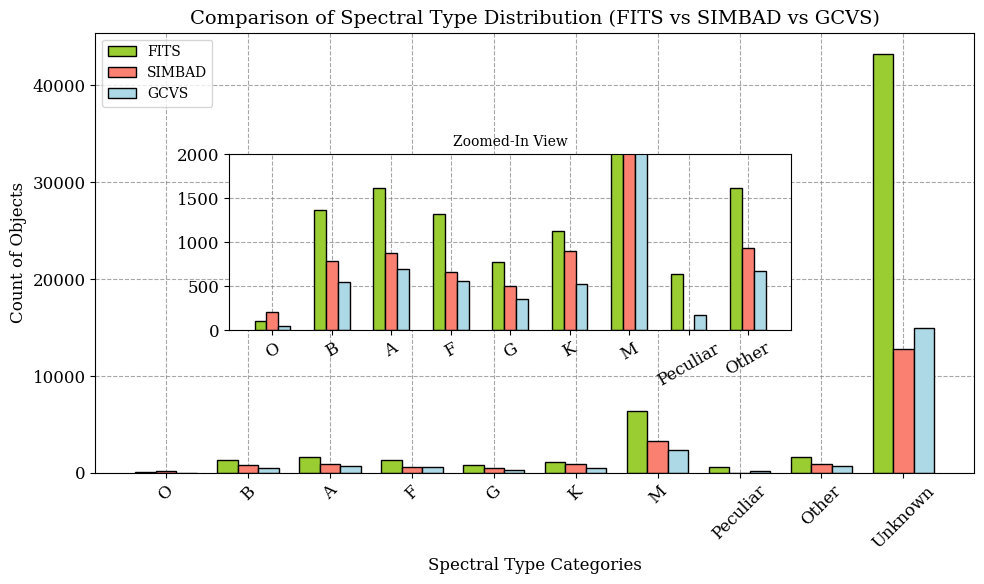

In [136]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from astropy.io import fits

# Функция для категоризации спектральных типов
def categorize_spectral_type(spectral_type):
    if pd.isnull(spectral_type) or spectral_type.strip() == '':
        return "Unknown"
    elif spectral_type.startswith('O'):
        return "O"
    elif spectral_type.startswith('B'):
        return "B"
    elif spectral_type.startswith('A'):
        return "A"
    elif spectral_type.startswith('F'):
        return "F"
    elif spectral_type.startswith('G'):
        return "G"
    elif spectral_type.startswith('K'):
        return "K"
    elif spectral_type.startswith('M'):
        return "M"
    elif "pec" in spectral_type.lower():
        return "Peculiar"
    else:
        return "Other"

# Загрузка FITS-файла
fits_data = fits.open("/Users/ildana/astro/fai/variable_search/catalogues/20240905_gsvs_catalogue.fits")
fits_df = pd.DataFrame(fits_data[1].data)

# Категоризация данных
desired_order = ["O", "B", "A", "F", "G", "K", "M", "Peculiar", "Other", "Unknown"]

fits_df['Category'] = fits_df['SPECT_TYPE'].apply(categorize_spectral_type)
df['Category_gcvs'] = df['SPECT_TYPE'].apply(categorize_spectral_type)
df['Category_simbad'] = df['SPEC_TYPE'].apply(categorize_spectral_type)

# Подсчет объектов по категориям
category_counts_fits = fits_df['Category'].value_counts().reindex(desired_order, fill_value=0)
category_counts_gcvs = df['Category_gcvs'].value_counts().reindex(desired_order, fill_value=0)
category_counts_simbad = df['Category_simbad'].value_counts().reindex(desired_order, fill_value=0)

# Вычисление статистики
total_objects = len(df)
matching_types = (df['Category_gcvs'] == df['Category_simbad']).sum()
match_percentage = (matching_types / total_objects) * 100

stats = {
    "Total Objects": total_objects,
    "Matching Spectral Types": matching_types,
    "Percentage Matching": f"{match_percentage:.2f}%",
    "Category Counts GCVS": category_counts_gcvs.to_dict(),
    "Category Counts SIMBAD": category_counts_simbad.to_dict()
}

print("Статистика совпадений:")
for key, value in stats.items():
    print(f"{key}: {value}")

# Формирование DataFrame для визуализации
category_data = pd.DataFrame({
    "Category": desired_order,
    "FITS": category_counts_fits.values,
    "SIMBAD": category_counts_simbad.values,
    "GCVS": category_counts_gcvs.values
})

# Визуализация распределения спектральных типов
fig, ax = plt.subplots(figsize=(10,6))

# Ширина и смещение для столбцов
bar_width = 0.25
x = range(len(desired_order))

# Построение столбцов
ax.bar([i - bar_width for i in x], category_data['FITS'], width=bar_width, label='FITS', color='yellowgreen', edgecolor='black')
ax.bar(x, category_data['SIMBAD'], width=bar_width, label='SIMBAD', color='salmon', edgecolor='black')
ax.bar([i + bar_width for i in x], category_data['GCVS'], width=bar_width, label='GCVS', color='lightblue', edgecolor='black')

# Настройка основного графика
ax.set_title('Comparison of Spectral Type Distribution (FITS vs SIMBAD vs GCVS)', fontsize=14)
ax.set_xlabel('Spectral Type Categories', fontsize=12)
ax.set_ylabel('Count of Objects', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(desired_order, rotation=45)
ax.legend()
ax.grid(linestyle='--', alpha=0.7)

# Добавление встроенного графика
inset_ax = inset_axes(ax, width="40%", height="40%", bbox_to_anchor=(-0.8, -0.26, 1.6, 1), bbox_transform=ax.transAxes)

# Построение данных для встроенного графика
inset_categories = ["O", "B", "A", "F", "G", "K", "M", "Peculiar", "Other"]  # Выбранные категории
category_subset_fits = category_counts_fits.loc[inset_categories]
category_subset_gcvs = category_counts_gcvs.loc[inset_categories]
category_subset_simbad = category_counts_simbad.loc[inset_categories]

inset_x = range(len(inset_categories))
bar_width_inset = 0.2

# Построение встроенных столбцов
inset_ax.bar([i - bar_width_inset for i in inset_x], category_subset_fits, width=bar_width_inset, label='FITS', color='yellowgreen', edgecolor='black')
inset_ax.bar(inset_x, category_subset_simbad, width=bar_width_inset, label='SIMBAD', color='salmon', edgecolor='black')
inset_ax.bar([i + bar_width_inset for i in inset_x], category_subset_gcvs, width=bar_width_inset, label='GCVS', color='lightblue', edgecolor='black')

# Настройка встроенного графика
inset_ax.set_title('Zoomed-In View', fontsize=10)
inset_ax.set_xticks(inset_x)
inset_ax.set_ylim(0, 2000)
inset_ax.set_xticklabels(inset_categories, rotation=30)
inset_ax.grid(linestyle='--', alpha=0.7)

# Сохранение графика
plt.tight_layout()
plt.savefig('output/variable_star_crossmatch/spectral_type_comparison.png', dpi=300)
plt.show()


### Create final column with spectra type info

In [141]:
# Добавляем SPEC_TYPE_FINAL, используя SPECT_TYPE и SPEC_TYPE
df['SPEC_TYPE_FINAL'] = df['SPECT_TYPE'].combine_first(df['SPEC_TYPE'])

# Добавляем Category_spec_final, используя Category_gcvs и Category_simbad
# Если в Category_gcvs указано 'Unknown', берем значение из Category_simbad
df['Category_spec_final'] = df.apply(
    lambda row: row['Category_simbad'] if row['Category_gcvs'] == 'Unknown' else row['Category_gcvs'],
    axis=1
)

# Проверяем результат
print(df[['SPECT_TYPE', 'SPEC_TYPE', 'SPEC_TYPE_FINAL', 'Category_gcvs', 'Category_simbad', 'Category_spec_final']].head())


  SPECT_TYPE SPEC_TYPE SPEC_TYPE_FINAL Category_gcvs Category_simbad  \
0       None      None            None       Unknown         Unknown   
1       None      None            None       Unknown         Unknown   
2       None      None            None       Unknown         Unknown   
3       None      None            None       Unknown         Unknown   
4       None    B1/2Ib          B1/2Ib       Unknown               B   

  Category_spec_final  
0             Unknown  
1             Unknown  
2             Unknown  
3             Unknown  
4                   B  


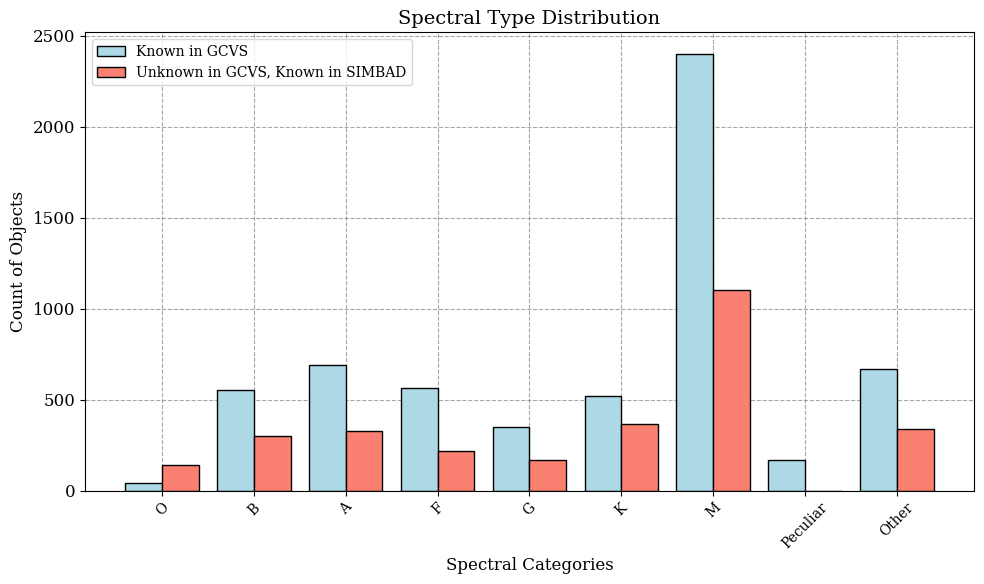

In [199]:
# Выделяем данные для анализа
known_in_gcvs = df[df['Category_gcvs'] != 'Unknown']['Category_gcvs']
unknown_in_gcvs_but_known_in_simbad = df[(df['Category_gcvs'] == 'Unknown') & (df['Category_simbad'].notna())]['Category_simbad']

# Обеспечиваем порядок категорий
desired_categories = ["O", "B", "A", "F", "G", "K", "M", "Peculiar", "Other"]

# Подготовка данных для графика
counts_gcvs = [known_in_gcvs.value_counts().get(cat, 0) for cat in desired_categories]
counts_simbad = [unknown_in_gcvs_but_known_in_simbad.value_counts().get(cat, 0) for cat in desired_categories]

# Индексы для категорий
x = range(len(desired_categories))

# Настройка графика
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.4

# Основные столбцы
ax.bar([i - bar_width / 2 for i in x], counts_gcvs, width=bar_width, 
       label='Known in GCVS', color='lightblue', edgecolor='black')
ax.bar([i + bar_width / 2 for i in x], counts_simbad, width=bar_width, 
       label='Unknown in GCVS, Known in SIMBAD', color='salmon', edgecolor='black')

# Настройка графика
ax.set_title('Spectral Type Distribution', fontsize=14)
ax.set_xlabel('Spectral Categories', fontsize=12)
ax.set_ylabel('Count of Objects', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(desired_categories, rotation=45, fontsize=10)
ax.legend(fontsize=10)
ax.grid(linestyle='--', alpha=0.7)

# Сохранение и отображение
plt.tight_layout()
plt.savefig('output/variable_star_crossmatch/unknown_gcvs_known_simbad_comparison.png', dpi=300)
plt.show()


## Variability type statistics

Summary Statistics:
Total Objects: 20961
Matching Variability Types: 6628
Percentage Matching: 31.62%
Category Counts GCVS: {'Pulsating': 9716, 'Unknown': 4401, 'Eclipsing': 3870, 'Eruptive': 1922, 'Rotating': 609, 'Cataclysmic': 273, 'New Types': 188, 'Other Symbols': 77, 'X-ray Sources': 38}
Category Counts SIMBAD: {'Unknown': 18604, 'Pulsating': 1248, 'Eclipsing': 764, 'Eruptive': 157, 'Rotating': 126, 'Cataclysmic': 97, 'Other Symbols': 25, 'New Types': 8}


/var/folders/kv/prhthx396zd4k1d7f55bdztc0000gn/T/ipykernel_14473/4059553564.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


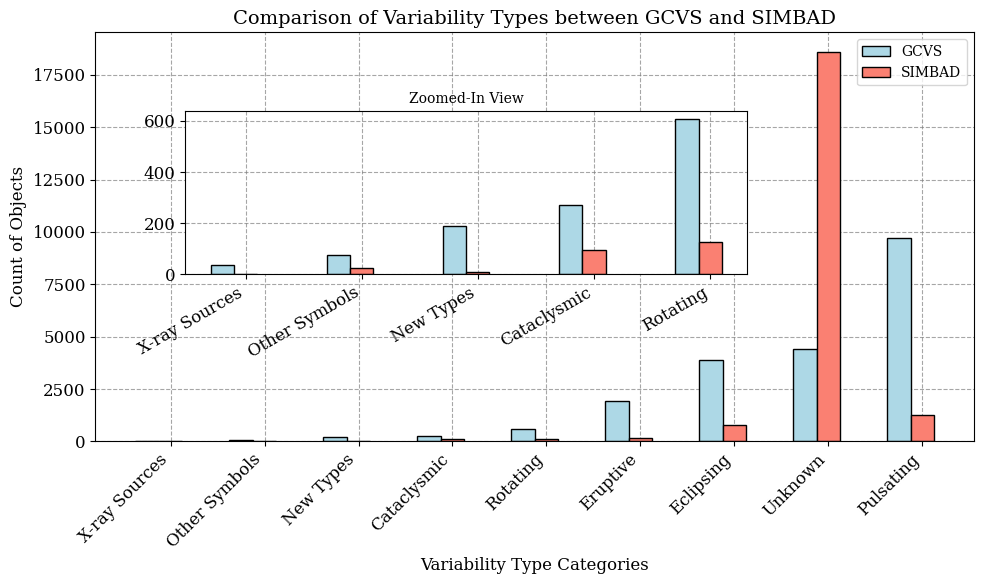

In [145]:
# Функция для классификации типа переменности
def categorize_variability_type(variability_type):
    # Словари категорий
    eruptive = {"FU", "GCAS", "I", "IA", "IB", "IN", "INA", "INB", "INT", "IT", "IN(YY)", "IS", "ISA", "ISB", "RCB", "RS", "SDOR", "UV", "UVN", "WR"}
    pulsating = {"ACYG", "BCEP", "BCEPS", "CEP", "CEP(B)", "CW", "CWA", "CWB", "DCEP", "DCEPS", "DSCT", "DSCTC", "GDOR", "L", "LB", "LC", "M", "PVTEL", "RPHS", "RR", "RR(B)", "RRAB", "RRC", "RV", "RVA", "RVB", "SR", "SRA", "SRB", "SRC", "SRD", "SXPHE", "ZZ", "ZZA", "ZZB"}
    rotating = {"ACV", "ACVO", "BY", "ELL", "FKCOM", "PSR", "SXARI"}
    cataclysmic = {"N", "NA", "NB", "NC", "NL", "NR", "SN", "SNI", "SNII", "UG", "UGSS", "UGSU", "UGZ", "ZAND"}
    eclipsing = {"E", "EA", "EB", "EW", "GS", "PN", "RS", "WD", "WR", "AR", "D", "DM", "DS", "DW", "K", "KE", "KW", "SD"}
    x_ray_sources = {"X", "XB", "XF", "XI", "XJ", "XND", "XNG", "XP", "XPR", "XPRM", "XM"}
    other_symbols = {"BLLAC", "CST", "GAL", "L:", "QSO", "S", "*", "+", ":"}
    new_types = {"ZZO", "AM", "R", "BE", "BLBOO", "EP", "SRS", "LPB(LBV)"}
    
    categories = {
        "Eruptive": eruptive,
        "Pulsating": pulsating,
        "Rotating": rotating,
        "Cataclysmic": cataclysmic,
        "Eclipsing": eclipsing,
        "X-ray Sources": x_ray_sources,
        "Other Symbols": other_symbols,
        "New Types": new_types
    }
    
    if pd.isna(variability_type):  # Проверка на None
        return ["Unknown"]
    
    # Удаляем пробелы и разделяем типы, если они комбинированные
    types = variability_type.replace(" ", "").split("+")
    
    # Определяем категории для типов
    category_list = []
    for t in types:
        for category, types_set in categories.items():
            if t in types_set:
                category_list.append(category)
                break
        else:
            category_list.append("Unknown")  # Если тип неизвестен
    
    return category_list

# Применение функции к данным
df['Category_var_gcvs'] = df['VARIABILITY_TYPE'].apply(categorize_variability_type)
df['Category_var_simbad'] = df['NEW_VARIABILITY_TYPE'].apply(categorize_variability_type)

# Сравнение категорий
comparison = df.apply(lambda row: set(row['Category_var_gcvs']) == set(row['Category_var_simbad']), axis=1)
matching_types = comparison.sum()
total = len(df)
match_percentage = matching_types / total * 100

# Подсчет по категориям
category_counts_gcvs = pd.Series([cat for sublist in df['Category_var_gcvs'] for cat in sublist]).value_counts()
category_counts_simbad = pd.Series([cat for sublist in df['Category_var_simbad'] for cat in sublist]).value_counts()

# Статистика совпадений и различий
stats = {
    "Total Objects": total,
    "Matching Variability Types": matching_types,
    "Percentage Matching": f"{match_percentage:.2f}%",
    "Category Counts GCVS": category_counts_gcvs.to_dict(),
    "Category Counts SIMBAD": category_counts_simbad.to_dict()
}

# Печать статистики
print("Summary Statistics:")
for key, value in stats.items():
    print(f"{key}: {value}")

# Подготовка данных для визуализации
category_data = pd.DataFrame({
    "Category": category_counts_gcvs.index,
    "GCVS": category_counts_gcvs.values,
    "SIMBAD": category_counts_simbad.reindex(category_counts_gcvs.index, fill_value=0).values
}).sort_values(by="GCVS", ascending=False)

# Сортировка данных
sorted_category_data = category_data.sort_values(by="GCVS")

# Визуализация основного графика
fig, ax = plt.subplots(figsize=(10, 6))

# Ширина и смещение для столбцов
bar_width = 0.25
x = range(len(sorted_category_data))

# Основные столбцы
ax.bar([i - bar_width for i in x], sorted_category_data['GCVS'], width=bar_width, label="GCVS", color="lightblue", edgecolor="black")
ax.bar(x, sorted_category_data['SIMBAD'], width=bar_width, label="SIMBAD", color="salmon", edgecolor="black")

# Настройка основного графика
ax.set_title('Comparison of Variability Types between GCVS and SIMBAD', fontsize=14)
ax.set_xlabel('Variability Type Categories', fontsize=12)
ax.set_ylabel('Count of Objects', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(sorted_category_data['Category'], rotation=45, ha="right")
ax.legend()
ax.grid(linestyle='--', alpha=0.7)



# Добавление встроенного графика
inset_ax = inset_axes(ax, width="40%", height="40%", bbox_to_anchor=(-0.85, -0.175, 1.6, 1), bbox_transform=ax.transAxes)

# Данные для встроенного графика
inset_categories = sorted_category_data.head(5)  # Используем только топ-5 категорий для увеличенного графика
inset_x = range(len(inset_categories))
bar_width_inset = 0.2

# Построение столбцов для встроенного графика
inset_ax.bar([i - bar_width_inset for i in inset_x], inset_categories['GCVS'], width=bar_width_inset, label="GCVS", color="lightblue", edgecolor="black")
inset_ax.bar(inset_x, inset_categories['SIMBAD'], width=bar_width_inset, label="SIMBAD", color="salmon", edgecolor="black")

# Настройка встроенного графика
inset_ax.set_title('Zoomed-In View', fontsize=10)
inset_ax.set_xticks(inset_x)
inset_ax.set_xticklabels(inset_categories['Category'], rotation=30, ha="right")
inset_ax.grid(linestyle='--', alpha=0.7)


# Сохранение и вывод графика
plt.tight_layout()
plt.savefig('output/variable_star_crossmatch/variability_type_comparison.png', dpi=300)
plt.show()



### Create final column with spectra type info

In [147]:
# Добавляем столбец для окончательной категории переменности
# Если в Category_var_gcvs указано 'Unknown', берем значение из Category_var_simbad
df['Category_var_final'] = df.apply(
    lambda row: row['Category_var_simbad'] if row['Category_var_gcvs'] == 'Unknown' else row['Category_var_gcvs'],
    axis=1
)

# Список категорий для упорядочивания
desired_var_order = ["Pulsating", "Eclipsing", "Rotating", "Cataclysmic", "Eruptive", "X-ray Sources", "New Types", "Other", "Unknown"]

# Фильтрация данных для объектов с 'Unknown' типом переменности в GCVS, но известным типом в SIMBAD
filtered_var_df = df[(df['Category_var_gcvs'] == 'Unknown') & (df['Category_var_simbad'] != 'Unknown')]

if not filtered_var_df.empty:
    # Распределение по типам переменности из SIMBAD
    simbad_var_distribution = filtered_var_df['Category_var_simbad'].value_counts()

    # Упорядочиваем распределение
    simbad_var_distribution = simbad_var_distribution.reindex(desired_var_order, fill_value=0)

    # Настройки графика
    bar_width = 0.5
    x = range(len(desired_var_order))

    # Построение графика
    plt.figure(figsize=(10, 6))
    plt.bar(x, simbad_var_distribution, width=bar_width, color="skyblue", edgecolor="black")

    # Установка подписей и заголовков
    plt.title("Distribution of Known Variability Types in SIMBAD for 'Unknown' Objects in GCVS", fontsize=14)
    plt.xlabel("SIMBAD Variability Categories", fontsize=12)
    plt.ylabel("Count of Objects", fontsize=12)
    plt.xticks(ticks=x, labels=desired_var_order, rotation=45)
    plt.grid(linestyle='--', alpha=0.7)

    # Отображение графика
    plt.tight_layout()
    plt.savefig('output/variable_star_crossmatch/distrib_unknown_gcvs_known_var_simb.png', dpi=300)
    plt.show()
else:
    print("There are no objects with 'Unknown' types in GCVS and known types in SIMBAD.")

# Проверяем результат
print(df[['Category_var_gcvs', 'Category_var_simbad', 'Category_var_final']].head())


There are no objects with 'Unknown' types in GCVS and known types in SIMBAD.
  Category_var_gcvs Category_var_simbad Category_var_final
0       [Eclipsing]           [Unknown]        [Eclipsing]
1         [Unknown]           [Unknown]          [Unknown]
2         [Unknown]           [Unknown]          [Unknown]
3       [Pulsating]           [Unknown]        [Pulsating]
4       [Pulsating]           [Unknown]        [Pulsating]


### Add parallax info from parced data

In [303]:
df_parallaxes = pd.read_csv("df_with_parallax.csv")
df_parallaxes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20961 entries, 0 to 20960
Data columns (total 76 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              20961 non-null  int64  
 1   Star NAME               20961 non-null  object 
 2   NAME                    20961 non-null  object 
 3   RA                      20961 non-null  float64
 4   DEC                     20961 non-null  float64
 5   SPECT_TYPE              5966 non-null   object 
 6   MIN_MAG_LIMIT           2837 non-null   object 
 7   MIN_MAG                 20961 non-null  float64
 8   MAX_MAG_LIMIT           0 non-null      float64
 9   MAX_MAG                 20961 non-null  float64
 10  VARIABILITY_TYPE        20572 non-null  object 
 11  PERIOD_LIMIT            53 non-null     object 
 12  PERIOD                  20961 non-null  float64
 13  PERIOD_FLAG             929 non-null    object 
 14  VARIABLE_STAR_NUMBER    20961 non-null

/var/folders/kv/prhthx396zd4k1d7f55bdztc0000gn/T/ipykernel_14473/1955102193.py:1: DtypeWarning: Columns (15,32,36,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  df_parallaxes = pd.read_csv("df_with_parallax.csv")


In [313]:
print(f"Now we know parallaxes of {18616/20961*100}% of objects")

Now we know parallaxes of 88.81255665283146% of objects


In [315]:
df = df.merge(df_parallaxes[['Star NAME', 'parallax']], on='Star NAME', how='left')


In [487]:
# Constants
R_sun = 8.2  # Distance from the Sun to the galactic center in kiloparsecs

# Helper function to calculate distance from galactic center
def calculate_galactic_distance(parallax, l_ii, b_ii):
    # Convert parallax to distance in kiloparsecs
    distance_to_object = 1 / parallax  # in kpc
    # Convert galactic coordinates to radians
    l_rad = np.radians(l_ii)
    b_rad = np.radians(b_ii)
    # Apply the formula for distance from the galactic center
    distance_to_center = np.sqrt(
        R_sun**2 + distance_to_object**2 - 
        2 * R_sun * distance_to_object * np.cos(l_rad) * np.cos(b_rad)
    )
    return distance_to_center

# Adding a new column to the dataset for distance to the galactic center
df['R_gal'] = calculate_galactic_distance(
    df['parallax'], df['LII'], df['BII']
)

In [489]:
df.head()

,Star NAME,NAME,RA,DEC,SPECT_TYPE,MIN_MAG_LIMIT,MIN_MAG,MAX_MAG_LIMIT,MAX_MAG,VARIABILITY_TYPE,...,Outlier_Amplitude,Outlier_PM_total,LII_bin,BII_bin,FULL_PERIOD_bin,Amplitude_bin,PM_total_bin,parallax,Outlier_parallax,R_gal
0,V537 Oph,V537 Oph,263.40392,-28.33603,None,None,12.80,None,12.50,EA,...,0,0,"(323.999, 359.999]","(0.0445, 17.952]","(-25.244, 2524.501]","(-3.2, 0.9]","(-0.00325, 0.325]",NaN,0,NaN
1,V542 Oph,V542 Oph,264.46142,-28.25281,None,None,13.30,None,12.80,EA/SD:,...,0,0,"(323.999, 359.999]","(0.0445, 17.952]","(-25.244, 2524.501]","(-3.2, 0.9]","(-0.00325, 0.325]",1.421584,0,7.496955
2,V973 Oph,V973 Oph,264.34904,-27.21147,None,None,13.50,None,12.60,ISB:,...,0,0,"(-0.36, 36.0]","(0.0445, 17.952]",NaN,"(-3.2, 0.9]","(-0.00325, 0.325]",0.754486,0,6.876103
3,V2738 Oph,V2738 Oph,263.80758,-27.05461,None,(,0.65,None,15.98,CWB,...,0,0,"(-0.36, 36.0]","(0.0445, 17.952]","(-25.244, 2524.501]",NaN,"(-0.00325, 0.325]",-0.154869,0,14.652248
4,V2371 Oph,V2371 Oph,261.14508,-26.92472,None,None,9.18,None,9.12,BCEP,...,0,0,"(323.999, 359.999]","(0.0445, 17.952]",NaN,"(-3.2, 0.9]","(-0.00325, 0.325]",1.091985,0,7.288258


## Outlayers

In [509]:
# Оптимизированная функция для маркировки выбросов
numeric_columns = ['FULL_PERIOD', 'Amplitude', 'PM_total', "parallax"]
def calculate_outlier_bounds(data, category_column, numeric_columns):
    # Словарь для хранения границ выбросов
    bounds = {numeric_column: {} for numeric_column in numeric_columns}
    
    # Рассчитываем границы IQR для каждой категории и параметра
    for numeric_column in numeric_columns:
        for category in data[category_column].unique():
            group_data = data[data[category_column] == category]
            Q1 = group_data[numeric_column].quantile(0.25)
            Q3 = group_data[numeric_column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            bounds[numeric_column][category] = (lower_bound, upper_bound)
    
    return bounds

def mark_outliers_with_precomputed_bounds(data, category_column, numeric_columns, bounds):
    # Добавляем столбцы для выбросов
    for numeric_column in numeric_columns:
        data[f'Outlier_{numeric_column}'] = 0  # Инициализация столбца
        for category, (lower_bound, upper_bound) in bounds[numeric_column].items():
            # Устанавливаем метку для выбросов
            mask = ((data[category_column] == category) &
                    ((data[numeric_column] < lower_bound) | (data[numeric_column] > upper_bound)))
            data.loc[mask, f'Outlier_{numeric_column}'] = 1
    return data

# Предварительный расчет границ
bounds = calculate_outlier_bounds(df, category_column='Category_spec_final', numeric_columns=numeric_columns)

# Маркировка выбросов с использованием предвычисленных границ
df = mark_outliers_with_precomputed_bounds(df, category_column='Category_spec_final', numeric_columns=numeric_columns, bounds=bounds)

# Проверка результата
df[[f'Outlier_{col}' for col in numeric_columns]]

,Outlier_FULL_PERIOD,Outlier_Amplitude,Outlier_PM_total,Outlier_parallax
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0
...,...,...,...,...
20956,0,0,0,0
20957,0,0,1,1
20958,0,0,0,0
20959,1,1,0,0


In [493]:
# Повторное создание таблицы outliers_count_df
# Function to detect outliers using IQR for a specific column in each category
def detect_outliers_by_category(data, category_column, numeric_column):
    outliers = {}
    for category in data[category_column].unique():
        # Выбор данных для текущей категории
        group_data = data[data[category_column] == category]
        
        # Расчёт межквартильного размаха (IQR)
        Q1 = group_data[numeric_column].quantile(0.25)
        Q3 = group_data[numeric_column].quantile(0.75)
        IQR = Q3 - Q1
        
        # Определение границ выбросов
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Выбор строк, где значения выходят за пределы
        group_outliers = group_data[(group_data[numeric_column] < lower_bound) |
                                    (group_data[numeric_column] > upper_bound)]
        outliers[category] = group_outliers  # Сохранение выбросов для категории
    return outliers


category_column = 'Category_spec_final'

outliers_summary = {}
for numeric_column in numeric_columns:
    outliers_summary[numeric_column] = detect_outliers_by_category(df, category_column, numeric_column)

outliers_count = {numeric_column: {category: len(outliers)
                                   for category, outliers in outliers_summary[numeric_column].items()}
                  for numeric_column in numeric_columns}

outliers_count_df = pd.DataFrame(outliers_count)

# Печать таблицы
print(outliers_count_df)


          FULL_PERIOD  Amplitude  PM_total  parallax  R_gal
Unknown          1639        984       988      1207   1391
B                  45         65        84        58     93
Other               3         60       102        45     79
Peculiar            7          1        35         5     23
F                  65         38        74        43    163
K                  47         37        94        16     62
A                  81         55        91        71    167
M                  28        179       259       197    457
G                  45         39        60        14     74
O                   3          8        15        10      7


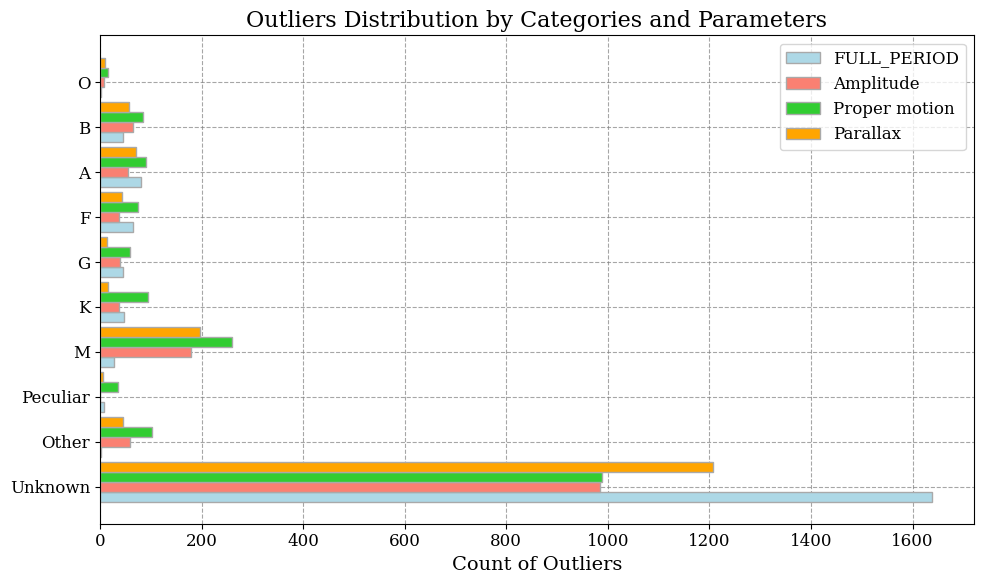

In [507]:
categories = ["O", "B", "A", "F", "G", "K", "M", "Peculiar", "Other", "Unknown"]
outliers_count_df = pd.DataFrame(outliers_count_df, index=categories)

# Создаем горизонтальный столбчатый график
fig, ax = plt.subplots(figsize=(10, 6))

# Increase spacing between categories
bar_width = 0.2
spacing = 0.9  # Spacing multiplier
x = np.arange(len(outliers_count_df.index) * spacing, step=spacing)[::-1]

# Столбцы для каждого параметра
bars_full_period = ax.barh(x - bar_width, outliers_count_df["FULL_PERIOD"], height=bar_width, label="FULL_PERIOD", color="lightblue", edgecolor="darkgray")
bars_amplitude = ax.barh(x, outliers_count_df["Amplitude"], height=bar_width, label="Amplitude", color="salmon", edgecolor="darkgray")
bars_pm_total = ax.barh(x + bar_width, outliers_count_df["PM_total"], height=bar_width, label="Proper motion", color="limegreen", edgecolor="darkgray")
bars_parallax = ax.barh(x + 2 * bar_width, outliers_count_df["parallax"], height=bar_width, label="Parallax", color="orange", edgecolor="darkgray")

# Настройка осей
ax.set_yticks(x)
ax.set_yticklabels(outliers_count_df.index, fontsize=12)
ax.set_xlabel("Count of Outliers", fontsize=14)
ax.set_title("Outliers Distribution by Categories and Parameters", fontsize=16)
ax.legend(fontsize=12)

# Добавление сетки
ax.grid(linestyle="--", alpha=0.7)

# Увеличиваем пространство между группами
plt.tight_layout()

# Сохраняем график
plt.savefig("output/variable_star_crossmatch/outliers_distribution.png", dpi=300)
plt.show()


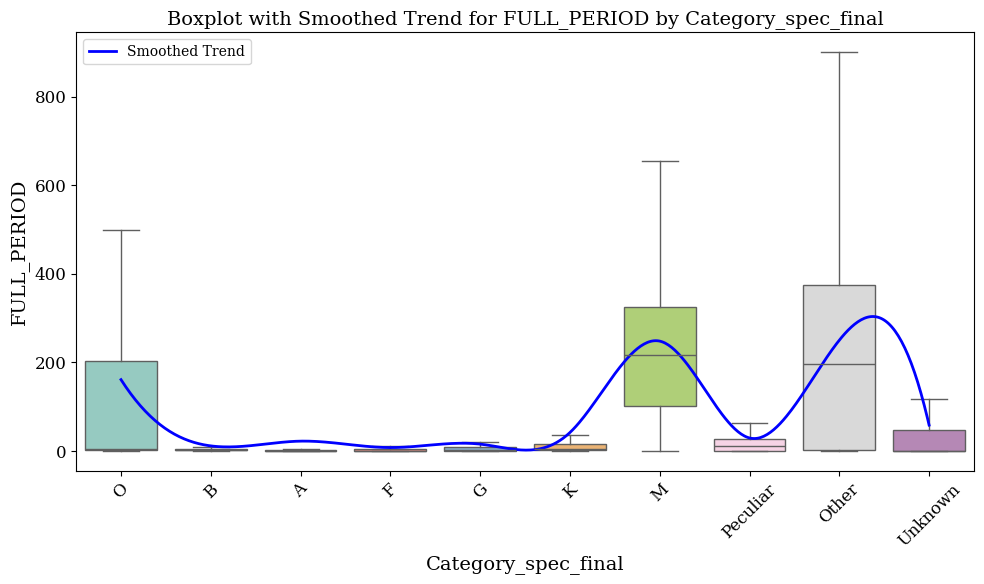

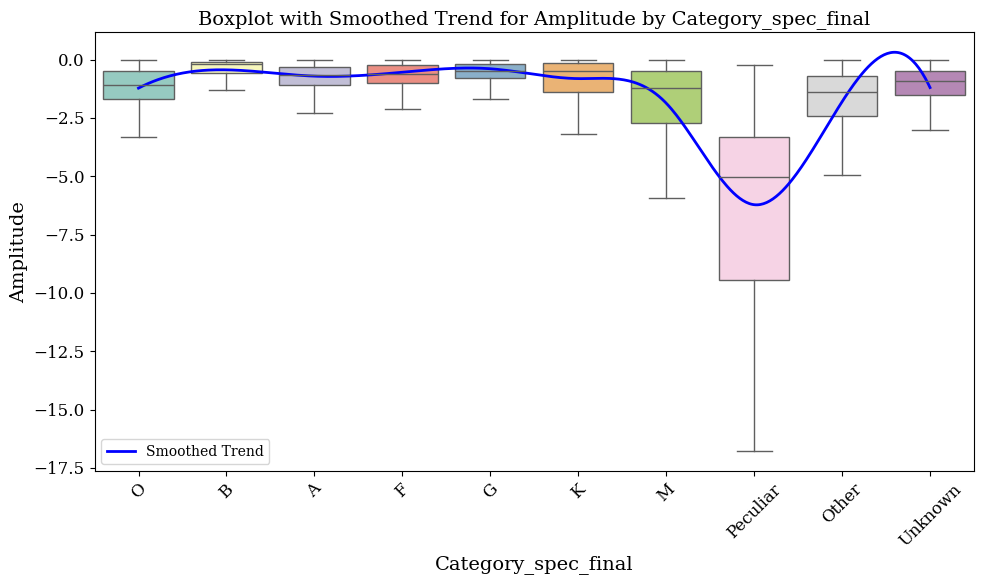

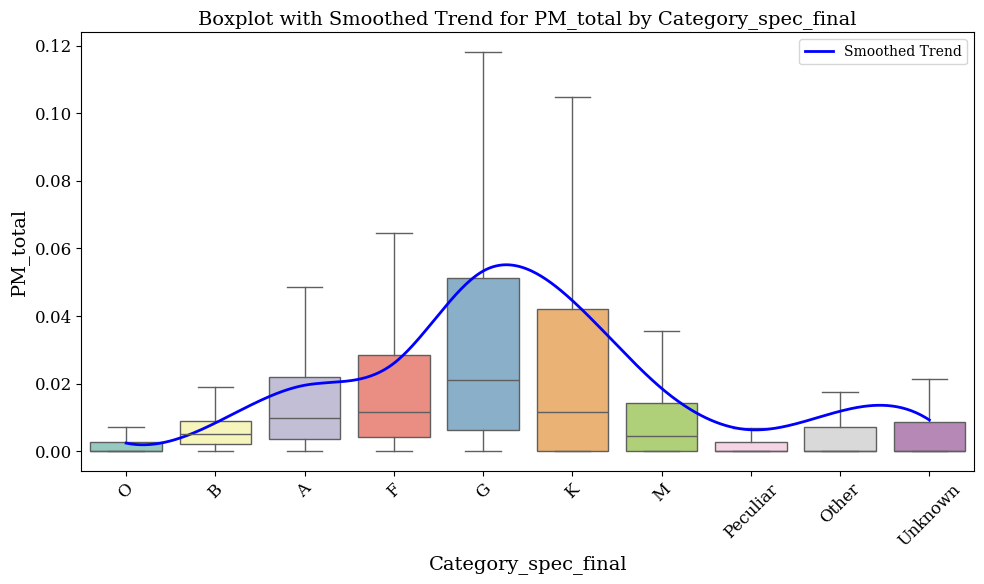

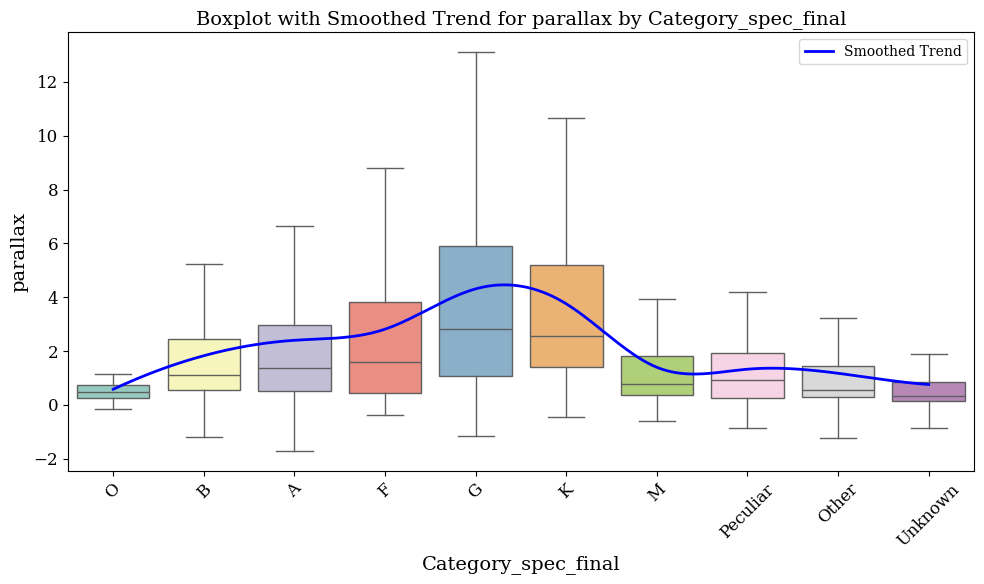

In [505]:
# Define the desired order for categories
desired_order = ["O", "B", "A", "F", "G", "K", "M", "Peculiar", "Other", "Unknown"]

# Plot for 'FULL_PERIOD', 'Amplitude', and 'PM_total' with the specified order
columns_to_plot = ['FULL_PERIOD', 'Amplitude', 'PM_total', "parallax"]

for column in columns_to_plot:
    # Calculate mean values for the current column grouped by 'Category_gcvs'
    mean_values = df.groupby('Category_spec_final')[column].mean()

    # Reindex to ensure the desired order
    means = mean_values.reindex(desired_order)
    x = np.arange(len(means))

    # Smooth curve
    spl = make_interp_spline(x, means)
    x_smooth = np.linspace(0, len(means)-1, 500)
    y_smooth = spl(x_smooth)

    # Plot the smooth line with boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x='Category_spec_final', y=column, showfliers=False, palette="Set3", order=desired_order)
    plt.plot(x_smooth, y_smooth, color='blue', label='Smoothed Trend', linewidth=2)
    plt.title(f"Boxplot with Smoothed Trend for {column} by Category_spec_final")
    plt.xlabel("Category_spec_final")
    plt.ylabel(column)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'output/variable_star_crossmatch/spect_type_{column}_trend.png', dpi=300)
    plt.show()



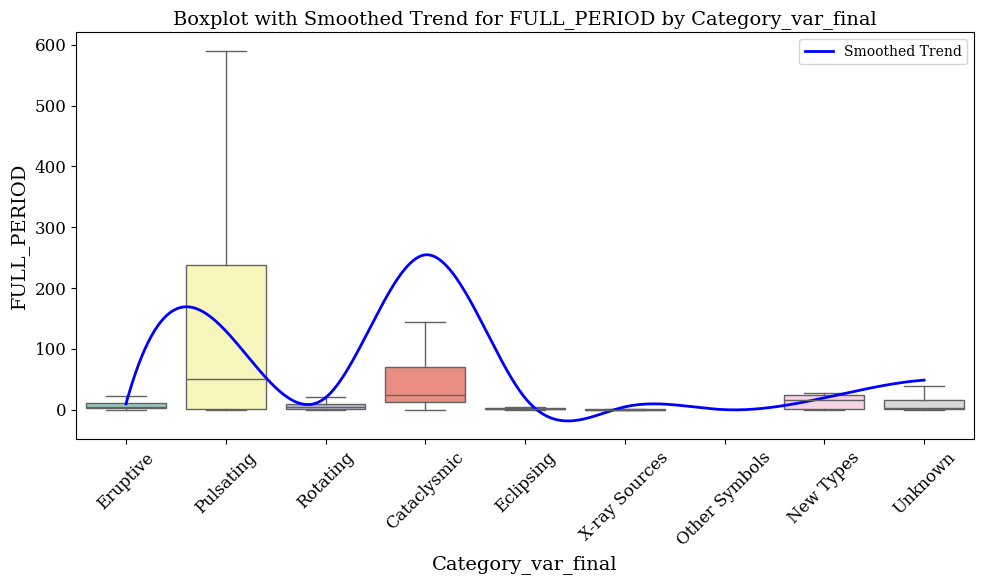

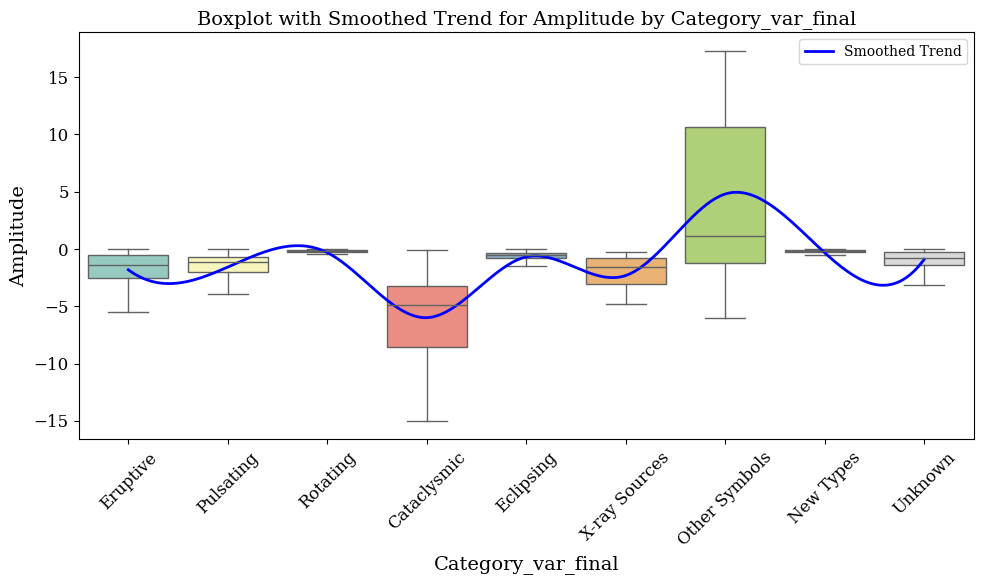

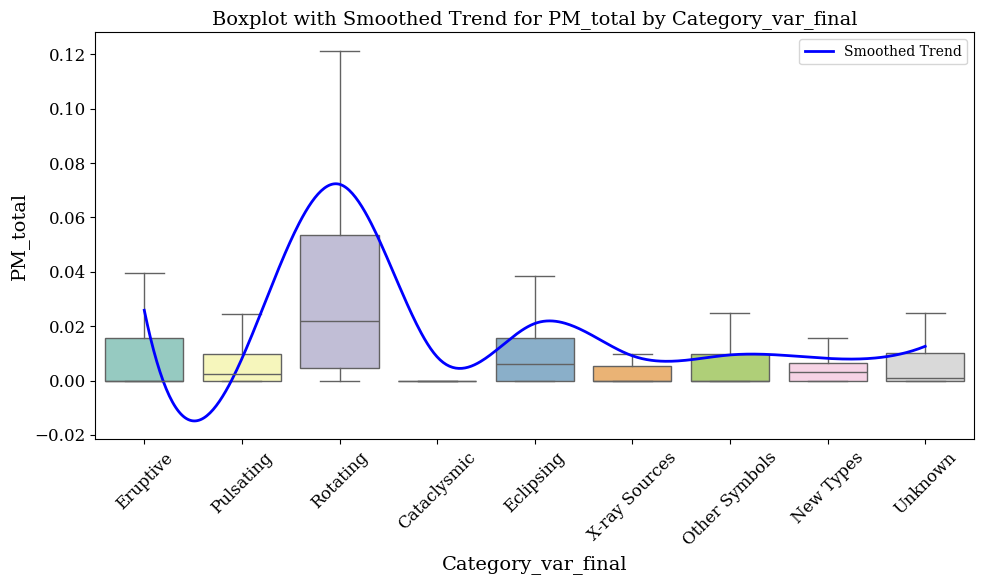

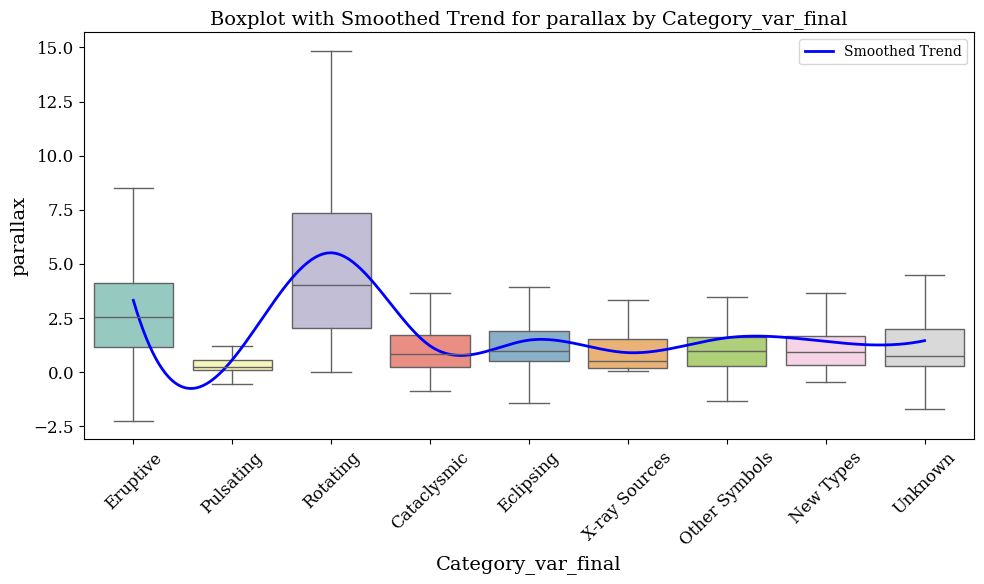

In [395]:
# Define the desired order for categories
desired_order = ["Eruptive", "Pulsating", "Rotating", "Cataclysmic", 
                 "Eclipsing", "X-ray Sources", "Other Symbols", 
                 "New Types", "Unknown"]

# Explode the 'Category_var_final' column (turn lists into multiple rows)
df_exploded = df.explode('Category_var_final')

# Plot for 'FULL_PERIOD', 'Amplitude', and 'PM_total' with the specified order
columns_to_plot = ['FULL_PERIOD', 'Amplitude', 'PM_total', "parallax"]

for column in columns_to_plot:
    # Calculate mean values for the current column grouped by 'Category_var_final'
    mean_values = df_exploded.groupby('Category_var_final')[column].mean()

    # Reindex to ensure the desired order
    means = mean_values.reindex(desired_order)
    means = means.fillna(0)  # Replace NaN with 0 to avoid errors in smoothing
    x = np.arange(len(means))

    # Smooth curve
    spl = make_interp_spline(x, means)
    x_smooth = np.linspace(0, len(means) - 1, 500)
    y_smooth = spl(x_smooth)

    # Plot the smooth line with boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_exploded, x='Category_var_final', y=column, 
                showfliers=False, palette="Set3", order=desired_order)
    plt.plot(x_smooth, y_smooth, color='blue', label='Smoothed Trend', linewidth=2)
    plt.title(f"Boxplot with Smoothed Trend for {column} by Category_var_final")
    plt.xlabel("Category_var_final")
    plt.ylabel(column)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'output/variable_star_crossmatch/var_type_{column}_trend.png', dpi=300)
    plt.show()


## Statistics measurments

In [503]:
from scipy.stats import chi2_contingency
import pandas as pd

# Удаление строк с NaN только из тех столбцов, которые участвуют в анализе
df_chi = df.dropna(subset=['FULL_PERIOD', 'Amplitude', 'PM_total','parallax'])

# Биннинг координат LII и BII
df_chi['LII_bin'] = pd.cut(df_chi['LII'], bins=10)
df_chi['BII_bin'] = pd.cut(df_chi['BII'], bins=10)

# Инициализация списка для результатов
results = []

# Функция для анализа одного параметра
def chi_square_analysis(param, category_column, enrichment_stage):
    print(f"Analyzing: {param}")
    # Биннинг параметра
    df_chi.loc[:, f'{param}_bin'] = pd.cut(df_chi[param], bins=10) if param not in ['LII_bin', 'BII_bin'] else df_chi[param]

    # Таблицы сопряжённости
    contingency_table_param = pd.crosstab(df_chi[f'{param}_bin'], df_chi[category_column])

    # Chi-square тест
    chi2, p, _, _ = chi2_contingency(contingency_table_param)

    # Сохранение результатов
    results.append({
        "Parameter": param,
        "Category Source": category_column,
        "Enrichment Stage": enrichment_stage,
        "Chi-square Value": chi2,
        "p-value": p
    })

# Список параметров для анализа
parameters = ['FULL_PERIOD', 'Amplitude', 'PM_total', 'LII_bin', 'BII_bin','parallax']

# Анализ до обогащения (Category_gcvs)
for param in parameters:
    chi_square_analysis(param, 'Category_gcvs', 'Before')

# Анализ после обогащения (Category_spec_final)
for param in parameters:
    chi_square_analysis(param, 'Category_spec_final', 'After')

# Создание DataFrame с результатами
chi_square_table_full = pd.DataFrame(results)

chi_square_table_full

/var/folders/kv/prhthx396zd4k1d7f55bdztc0000gn/T/ipykernel_14473/2012053944.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chi['LII_bin'] = pd.cut(df_chi['LII'], bins=10)
/var/folders/kv/prhthx396zd4k1d7f55bdztc0000gn/T/ipykernel_14473/2012053944.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chi['BII_bin'] = pd.cut(df_chi['BII'], bins=10)


Analyzing: FULL_PERIOD
Analyzing: Amplitude
Analyzing: PM_total
Analyzing: LII_bin
Analyzing: BII_bin
Analyzing: parallax
Analyzing: FULL_PERIOD
Analyzing: Amplitude
Analyzing: PM_total
Analyzing: LII_bin
Analyzing: BII_bin
Analyzing: parallax


/var/folders/kv/prhthx396zd4k1d7f55bdztc0000gn/T/ipykernel_14473/2012053944.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chi.loc[:, f'{param}_bin'] = pd.cut(df_chi[param], bins=10) if param not in ['LII_bin', 'BII_bin'] else df_chi[param]
/var/folders/kv/prhthx396zd4k1d7f55bdztc0000gn/T/ipykernel_14473/2012053944.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chi.loc[:, f'{param}_bin'] = pd.cut(df_chi[param], bins=10) if param not in ['LII_bin', 'BII_bin'] else df_chi[param]
/var/folders

,Parameter,Category Source,Enrichment Stage,Chi-square Value,p-value
0,FULL_PERIOD,Category_gcvs,Before,58.868502,9.446099e-03
1,Amplitude,Category_gcvs,Before,2092.807729,0.000000e+00
2,PM_total,Category_gcvs,Before,112.522344,1.179004e-02
3,LII_bin,Category_gcvs,Before,771.671919,3.419666e-113
4,BII_bin,Category_gcvs,Before,453.264722,3.832338e-53
5,parallax,Category_gcvs,Before,1440.801274,1.613887e-272
6,FULL_PERIOD,Category_spec_final,After,66.018093,1.664378e-03
7,Amplitude,Category_spec_final,After,2062.535664,0.000000e+00
8,PM_total,Category_spec_final,After,115.214197,7.489997e-03
9,LII_bin,Category_spec_final,After,846.929292,6.082345e-128


In [399]:
from scipy.stats import chi2_contingency
import pandas as pd

# Удаление строк с NaN только из тех столбцов, которые участвуют в анализе
df_chi = df.dropna(subset=['FULL_PERIOD', 'Amplitude', 'PM_total','parallax'])

# Разворачиваем списки в 'Category_var_final'
df_exploded = df_chi.explode('Category_var_final')

# Биннинг координат LII и BII
df_exploded['LII_bin'] = pd.cut(df_exploded['LII'], bins=10)
df_exploded['BII_bin'] = pd.cut(df_exploded['BII'], bins=10)

# Инициализация списка для результатов
results_var = []

# Функция для анализа одного параметра с типом переменности
def chi_square_analysis_var(param, category_column):
    print(f"Analyzing: {param}")
    # Биннинг параметра
    df_exploded.loc[:, f'{param}_bin'] = pd.cut(df_exploded[param], bins=10) if param not in ['LII_bin', 'BII_bin'] else df_exploded[param]

    # Таблицы сопряжённости
    contingency_table_param = pd.crosstab(df_exploded[f'{param}_bin'], df_exploded[category_column])

    # Chi-square тест
    chi2, p, _, _ = chi2_contingency(contingency_table_param)

    # Сохранение результатов
    results_var.append({
        "Parameter": param,
        "Category Source": category_column,
        "Chi-square Value": chi2,
        "p-value": p
    })

# Список параметров для анализа
parameters = ['FULL_PERIOD', 'Amplitude', 'PM_total', 'LII_bin', 'BII_bin','parallax']

# Анализ для типа переменности (Category_var_final)
for param in parameters:
    chi_square_analysis_var(param, 'Category_var_final')

# Создание DataFrame с результатами
chi_square_table_var = pd.DataFrame(results_var)
chi_square_table_var

Analyzing: FULL_PERIOD
Analyzing: Amplitude
Analyzing: PM_total
Analyzing: LII_bin
Analyzing: BII_bin
Analyzing: parallax


,Parameter,Category Source,Chi-square Value,p-value
0,FULL_PERIOD,Category_var_final,25.189756,6.174886e-01
1,Amplitude,Category_var_final,1326.728106,9.264895e-251
2,PM_total,Category_var_final,404.959953,2.049225e-51
3,LII_bin,Category_var_final,1508.869935,9.350378e-274
4,BII_bin,Category_var_final,578.785019,1.880938e-84
5,parallax,Category_var_final,1076.792220,2.096826e-203


Корреляционная матрица сохранена в файл 'correlation_matrix.csv'.


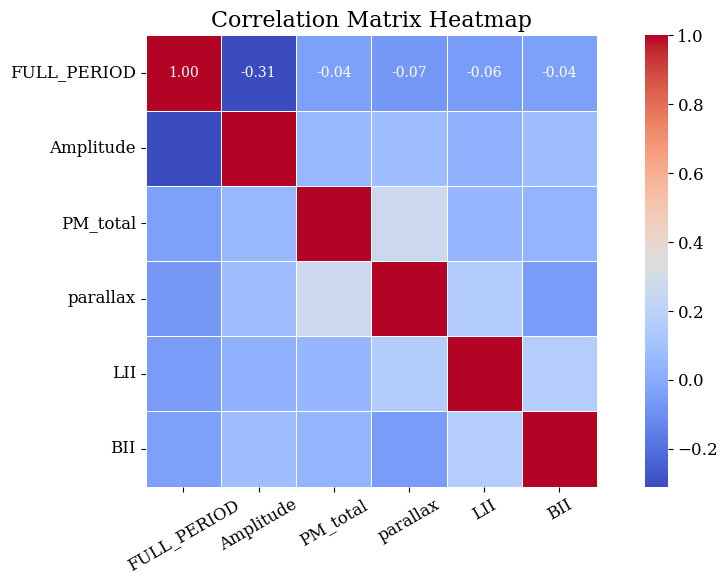

In [511]:
# Выбор числовых столбцов для корреляции
numerical_columns = ['FULL_PERIOD', 'Amplitude',  'PM_total','parallax', "LII", "BII"]

# Вычисление корреляционной матрицы
correlation_matrix = df[numerical_columns].corr()

# Сохранение результата в файл для просмотра
correlation_matrix.to_csv("correlation_matrix.csv", index=True)

print("Корреляционная матрица сохранена в файл 'correlation_matrix.csv'.")



# Предположим, что у нас есть матрица корреляций `correlation_matrix`
plt.figure(figsize=(10, 6))

# Построение тепловой карты с числовыми значениями в каждой ячейке и без цветовой шкалы
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm",  square=True, 
            linewidths=0.5, annot_kws={"size": 10})
plt.xticks(rotation=30)
# Добавление заголовка и настройка макета
plt.title("Correlation Matrix Heatmap", fontsize=16)
plt.tight_layout()


# Save the heatmap as an image file
plt.savefig("output/variable_star_crossmatch/correlation_matrix_heatmap_no_cbar.png", dpi=300)

plt.show()


/var/folders/kv/prhthx396zd4k1d7f55bdztc0000gn/T/ipykernel_14473/3672770997.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  density_table = df.groupby(['LII_bin', 'BII_bin']).size().reset_index(name='Object_Count')


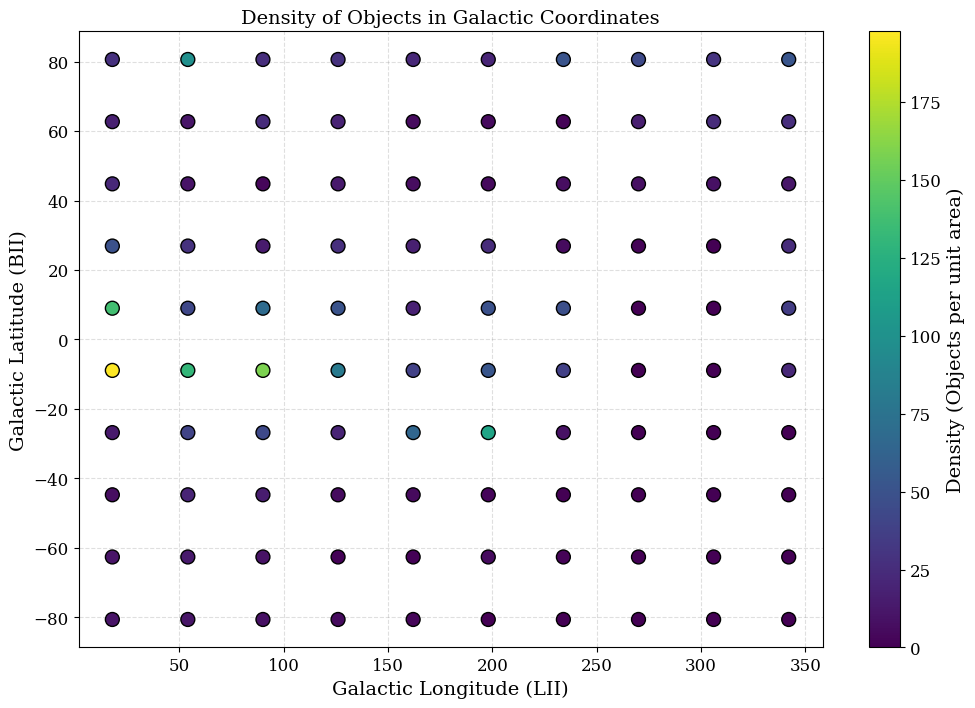

In [74]:
# Задаем количество интервалов для LII и BII
bins = 10
df['LII_bin'] = pd.cut(df['LII'], bins=bins)
df['BII_bin'] = pd.cut(df['BII'], bins=bins)

# Подсчитываем количество объектов в каждой ячейке
density_table = df.groupby(['LII_bin', 'BII_bin']).size().reset_index(name='Object_Count')

# Извлечение границ интервалов с преобразованием в float
density_table['LII_left'] = density_table['LII_bin'].apply(lambda x: x.left).astype(float)
density_table['LII_right'] = density_table['LII_bin'].apply(lambda x: x.right).astype(float)
density_table['BII_left'] = density_table['BII_bin'].apply(lambda x: x.left).astype(float)
density_table['BII_right'] = density_table['BII_bin'].apply(lambda x: x.right).astype(float)

# Рассчитываем площади ячеек
density_table['Area'] = (
    np.sin(np.radians(density_table['BII_right'])) -
    np.sin(np.radians(density_table['BII_left']))
) * (
    density_table['LII_right'] - density_table['LII_left']
)

# Рассчитываем плотность объектов
density_table['Density'] = density_table['Object_Count'] / density_table['Area']

# Вывод таблицы для проверки
density_table[['LII_bin', 'BII_bin', 'Object_Count', 'Area', 'Density']]


# Центры ячеек для визуализации
density_table['LII_center'] = (density_table['LII_left'] + density_table['LII_right']) / 2
density_table['BII_center'] = (density_table['BII_left'] + density_table['BII_right']) / 2

# Создаем график
plt.figure(figsize=(12, 8))
plt.scatter(density_table['LII_center'], density_table['BII_center'], 
            c=density_table['Density'], cmap='viridis', s=100, edgecolor='k')
plt.colorbar(label='Density (Objects per unit area)')
plt.title('Density of Objects in Galactic Coordinates')
plt.xlabel('Galactic Longitude (LII)')
plt.ylabel('Galactic Latitude (BII)')
plt.grid()
plt.show()


## Machine learning

In [405]:
df.to_csv("final_catalogue.csv")

In [409]:
df.columns

Index(['Star NAME', 'NAME', 'RA', 'DEC', 'SPECT_TYPE', 'MIN_MAG_LIMIT',
       'MIN_MAG', 'MAX_MAG_LIMIT', 'MAX_MAG', 'VARIABILITY_TYPE',
       'PERIOD_LIMIT', 'PERIOD', 'PERIOD_FLAG', 'VARIABLE_STAR_NUMBER',
       'VARIABLE_STAR_CPT', 'NOTE_FLAG', 'LII', 'BII', 'POSITION_FLAG',
       'MAX_MAG_FLAG', 'MIN_MAG_FLAG', 'MIN_MAG_ALT_SYS', 'SEC_MIN_MAG_LIMIT',
       'SEC_MIN_MAG', 'SEC_MIN_MAG_FLAG', 'SEC_MIN_MAG_ALT_SYS', 'MAG_SYSTEM',
       'EPOCH', 'EPOCH_PRECISION', 'EPOCH_FLAG', 'NOVA_YEAR', 'NOVA_YEAR_FLAG',
       'PERIOD_PRECISION', 'PERIOD_NOTE', 'RISE_ECLIPSE_TIME',
       'RISE_ECLIPSE_TIME_FLAG', 'ECLIPSE_VAR_NOTE', 'REF_STAR', 'REF_CHART',
       'COMMENT_FLAG', 'ALT_NAME', 'PM_RA', 'PM_DEC', 'COORDINATES_EPOCH',
       'COORDINATES_EPOCH_FLAG', 'REF_ASTROMETRY_FLAG', 'REF_ASTROMETRY',
       'NEW_VARIABILITY_TYPE', 'CLASS', 'Frames', 'RA/DEC Coordinates',
       'Pixel Coordinates', 'OBJ_TYPE', 'OBJ_TYPE_REF', 'SPEC_TYPE',
       'SPEC_TYPE_REF', 'NAME_SIMBAD', 'RA_SIMBAD

### Clean data

In [462]:
# Checking if the specified columns are in the dataset
required_columns = ['FULL_PERIOD', 'Amplitude', 'PM_total', 'parallax', 'LII', 'BII', 'Category_spec_final', 'Category_var_final']

# Удаляем строки, где 'Category_spec_final' равно 'Unknown' или 'Other'
filtered_data = cleaned_data[
    (cleaned_data['Category_spec_final'] != 'Unknown') & 
    (cleaned_data['Category_spec_final'] != 'Other')
]

# Удаляем строки, где 'Category_var_final' равно 'Unknown' или 'Other Symbols'
filtered_data = filtered_data[
    (filtered_data['Category_var_final'] != 'Unknown') & 
    (filtered_data['Category_var_final'] != 'Other Symbols')
]

# Selecting only the relevant columns
selected_data = filtered_data[required_columns]

# Dropping rows with missing values in the selected columns
cleaned_data = selected_data.dropna()

# Checking the distribution of the target variables
spec_distribution = cleaned_data['Category_spec_final'].value_counts()
var_distribution = cleaned_data['Category_var_final'].value_counts()

spec_distribution, var_distribution

# Combining rare classes in spectral and variability categories
# Converting problematic column to strings to avoid unhashable type errors
cleaned_data['Category_var_final'] = cleaned_data['Category_var_final'].astype(str)

# Threshold for rare classes
rare_threshold_spec = 100
rare_threshold_var = 50

# Combining rare classes in spectral type
cleaned_data['Category_spec_final'] = cleaned_data['Category_spec_final'].apply(
    lambda x: x if cleaned_data['Category_spec_final'].value_counts()[x] >= rare_threshold_spec else 'Other'
)

# Combining rare classes in variability type
cleaned_data['Category_var_final'] = cleaned_data['Category_var_final'].apply(
    lambda x: x if cleaned_data['Category_var_final'].value_counts()[x] >= rare_threshold_var else "['Other']"
)

# Encoding target variables
spec_label_encoder = LabelEncoder()
cleaned_data['Category_spec_encoded'] = spec_label_encoder.fit_transform(cleaned_data['Category_spec_final'])

var_label_encoder = LabelEncoder()
cleaned_data['Category_var_encoded'] = var_label_encoder.fit_transform(cleaned_data['Category_var_final'])

# Selecting features and targets
X = cleaned_data[['FULL_PERIOD', 'Amplitude', 'PM_total', 'parallax', 'LII', 'BII']]
y_spec = cleaned_data['Category_spec_encoded']
y_var = cleaned_data['Category_var_encoded']

# Scaling the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting data into training and testing sets for both targets
X_train_spec, X_test_spec, y_train_spec, y_test_spec = train_test_split(
    X_scaled, y_spec, test_size=0.2, random_state=42, stratify=y_spec
)
X_train_var, X_test_var, y_train_var, y_test_var = train_test_split(
    X_scaled, y_var, test_size=0.2, random_state=42, stratify=y_var
)

# Displaying the prepared data shapes
(X_train_spec.shape, X_test_spec.shape, y_train_spec.shape, y_test_spec.shape,
 X_train_var.shape, X_test_var.shape, y_train_var.shape, y_test_var.shape)



((2746, 6), (687, 6), (2746,), (687,), (2746, 6), (687, 6), (2746,), (687,))

### Gradient Boosting

#### XGBClassifier

In [515]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

# Initializing XGBoost classifiers for both tasks
xgb_spec = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb_var = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

# Training the models
xgb_spec.fit(X_train_spec, y_train_spec)
xgb_var.fit(X_train_var, y_train_var)

# Making predictions
y_pred_spec = xgb_spec.predict(X_test_spec)
y_pred_var = xgb_var.predict(X_test_var)

# Evaluating the models
spec_report = classification_report(y_test_spec, y_pred_spec, target_names=spec_label_encoder.classes_)
var_report = classification_report(y_test_var, y_pred_var, target_names=var_label_encoder.classes_)

spec_accuracy = accuracy_score(y_test_spec, y_pred_spec)
var_accuracy = accuracy_score(y_test_var, y_pred_var)

# Returning the evaluation metrics
# Creating dataframes for classification reports
spec_report_df = pd.DataFrame(classification_report(y_test_spec, y_pred_spec, target_names=spec_label_encoder.classes_, output_dict=True)).T
var_report_df = pd.DataFrame(classification_report(y_test_var, y_pred_var, target_names=var_label_encoder.classes_, output_dict=True)).T

/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [517]:
spec_report_df

,precision,recall,f1-score,support
A,0.554839,0.618705,0.585034,139.000000
B,0.500000,0.474359,0.486842,78.000000
F,0.421569,0.430000,0.425743,100.000000
G,0.208333,0.119048,0.151515,42.000000
K,0.312500,0.147059,0.200000,34.000000
M,0.920886,0.989796,0.954098,294.000000
accuracy,0.679767,0.679767,0.679767,0.679767
macro avg,0.486354,0.463161,0.467205,687.000000
weighted avg,0.652686,0.679767,0.663080,687.000000


In [518]:
var_report_df

,precision,recall,f1-score,support
['Eclipsing'],0.635659,0.713043,0.672131,115.000000
['Eruptive'],0.500000,0.450000,0.473684,20.000000
['Other'],0.000000,0.000000,0.000000,9.000000
['Pulsating'],0.867925,0.931646,0.898657,395.000000
['Rotating'],0.416667,0.277778,0.333333,18.000000
['Unknown'],0.544554,0.423077,0.476190,130.000000
accuracy,0.755459,0.755459,0.755459,0.755459
macro avg,0.494134,0.465924,0.475666,687.000000
weighted avg,0.733949,0.755459,0.741838,687.000000


In [473]:
# Analyzing feature importance for the spectral type model
feature_importance_spec = pd.DataFrame({
    'Feature': ['FULL_PERIOD', 'Amplitude', 'PM_total', 'parallax', 'LII', 'BII'],
    'Importance': xgb_spec.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Analyzing feature importance for the variability type model
feature_importance_var = pd.DataFrame({
    'Feature': ['FULL_PERIOD', 'Amplitude', 'PM_total', 'parallax', 'LII', 'BII'],
    'Importance': xgb_var.feature_importances_
}).sort_values(by='Importance', ascending=False)


In [475]:
feature_importance_spec

,Feature,Importance
0,FULL_PERIOD,0.468891
3,parallax,0.119057
1,Amplitude,0.116226
5,BII,0.105135
2,PM_total,0.101819
4,LII,0.088872


In [477]:
feature_importance_var

,Feature,Importance
0,FULL_PERIOD,0.347120
3,parallax,0.189118
1,Amplitude,0.178884
4,LII,0.102607
2,PM_total,0.092612
5,BII,0.089658


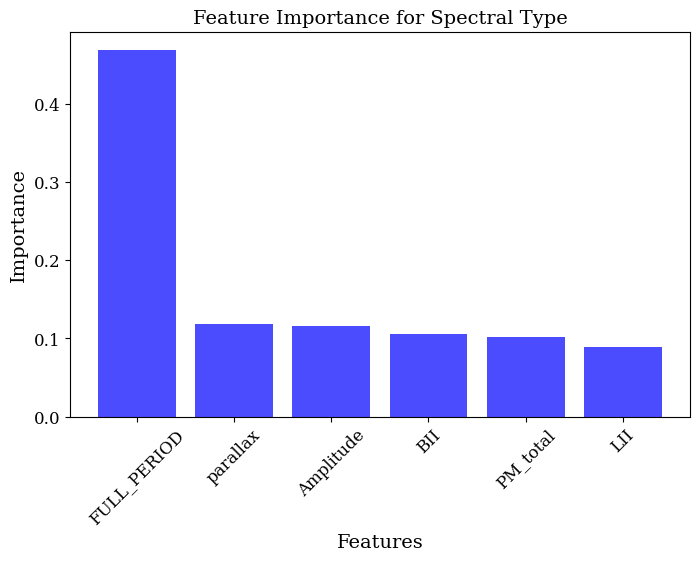

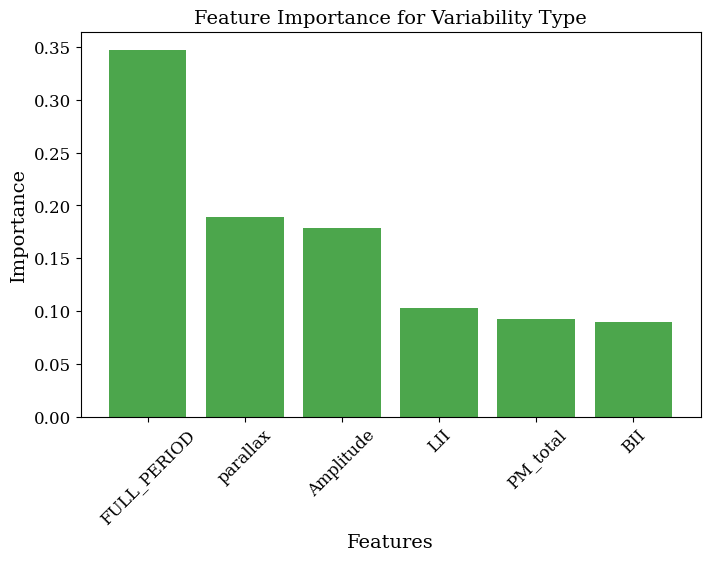

In [513]:
# Plotting feature importance for Spectral Type
plt.figure(figsize=(8, 5))
plt.bar(feature_importance_spec['Feature'], feature_importance_spec['Importance'], color='blue', alpha=0.7)
plt.title('Feature Importance for Spectral Type')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.xticks(rotation=45)
plt.show()

# Plotting feature importance for Variability Type
plt.figure(figsize=(8, 5))
plt.bar(feature_importance_var['Feature'], feature_importance_var['Importance'], color='green', alpha=0.7)
plt.title('Feature Importance for Variability Type')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.xticks(rotation=45)
plt.show()


/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:57:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


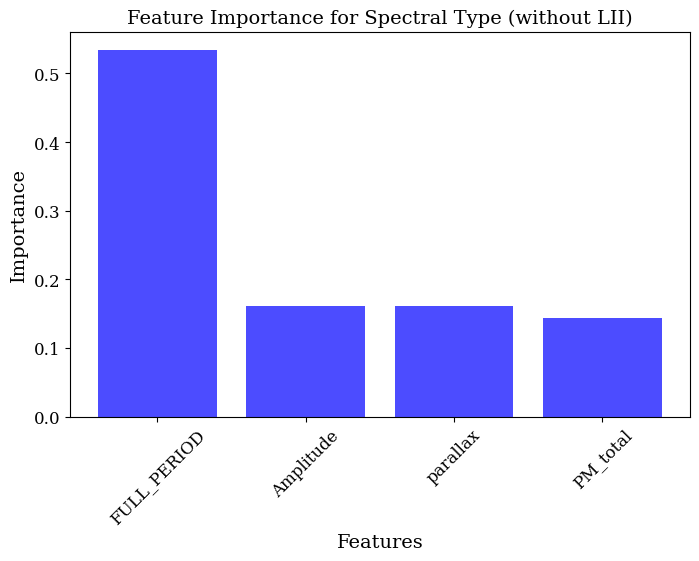

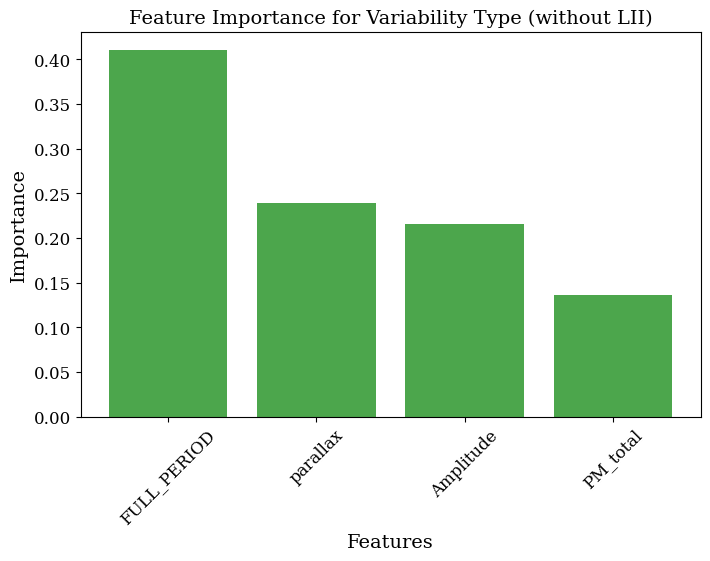

In [527]:

# Dropping longitude (LII)
X_reduced = cleaned_data[['FULL_PERIOD', 'Amplitude', 'PM_total', 'parallax']]
X_reduced_scaled = scaler.fit_transform(X_reduced)

# Splitting data without LII for both tasks
X_train_spec_red, X_test_spec_red, y_train_spec_red, y_test_spec_red = train_test_split(
    X_reduced_scaled, y_spec, test_size=0.2, random_state=42, stratify=y_spec
)
X_train_var_red, X_test_var_red, y_train_var_red, y_test_var_red = train_test_split(
    X_reduced_scaled, y_var, test_size=0.2, random_state=42, stratify=y_var
)

# Re-training models without LII
xgb_spec.fit(X_train_spec_red, y_train_spec_red)
xgb_var.fit(X_train_var_red, y_train_var_red)

# Analyzing feature importance again
feature_importance_spec_red = pd.DataFrame({
    'Feature': ['FULL_PERIOD', 'Amplitude', 'PM_total', 'parallax'],
    'Importance': xgb_spec.feature_importances_
}).sort_values(by='Importance', ascending=False)

feature_importance_var_red = pd.DataFrame({
    'Feature': ['FULL_PERIOD', 'Amplitude', 'PM_total', 'parallax'],
    'Importance': xgb_var.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plotting feature importance without LII for Spectral Type
plt.figure(figsize=(8, 5))
plt.bar(feature_importance_spec_red['Feature'], feature_importance_spec_red['Importance'], color='blue', alpha=0.7)
plt.title('Feature Importance for Spectral Type (without LII)')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.xticks(rotation=45)
plt.show()

# Plotting feature importance without LII for Variability Type
plt.figure(figsize=(8, 5))
plt.bar(feature_importance_var_red['Feature'], feature_importance_var_red['Importance'], color='green', alpha=0.7)
plt.title('Feature Importance for Variability Type (without LII)')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.xticks(rotation=45)
plt.show()







In [529]:
# Initializing XGBoost classifiers for both tasks
xgb_spec_red = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb_var_red = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

# Training the models
xgb_spec_red.fit(X_train_spec_red, y_train_spec_red)
xgb_var_red.fit(X_train_var_red, y_train_var_red)

# Making predictions
y_pred_spec_red = xgb_spec.predict(X_test_spec_red)
y_pred_var_red = xgb_var.predict(X_test_var_red)

# Evaluating the models
spec_report_red = classification_report(y_test_spec_red, y_pred_spec_red, target_names=spec_label_encoder.classes_)
var_report_red = classification_report(y_test_var_red, y_pred_var_red, target_names=var_label_encoder.classes_)

spec_accuracy_red = accuracy_score(y_test_spec_red, y_pred_spec_red)
var_accuracy_red = accuracy_score(y_test_var_red, y_pred_var_red)

# Returning the evaluation metrics
# Creating dataframes for classification reports
spec_report_red_df = pd.DataFrame(classification_report(y_test_spec_red, y_pred_spec_red, target_names=spec_label_encoder.classes_, output_dict=True)).T
var_report_red_df = pd.DataFrame(classification_report(y_test_var_red, y_pred_var_red, target_names=var_label_encoder.classes_, output_dict=True)).T

/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:57:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [531]:
spec_report_red_df

,precision,recall,f1-score,support
A,0.519231,0.582734,0.549153,139.0000
B,0.469136,0.487179,0.477987,78.0000
F,0.414141,0.410000,0.412060,100.0000
G,0.291667,0.166667,0.212121,42.0000
K,0.181818,0.117647,0.142857,34.0000
M,0.931148,0.965986,0.948247,294.0000
accuracy,0.662300,0.662300,0.662300,0.6623
macro avg,0.467857,0.455036,0.457071,687.0000
weighted avg,0.643914,0.662300,0.651197,687.0000


In [532]:
var_report_red_df

,precision,recall,f1-score,support
['Eclipsing'],0.530769,0.600000,0.563265,115.000000
['Eruptive'],0.384615,0.250000,0.303030,20.000000
['Other'],0.000000,0.000000,0.000000,9.000000
['Pulsating'],0.871734,0.929114,0.899510,395.000000
['Rotating'],0.312500,0.277778,0.294118,18.000000
['Unknown'],0.456311,0.361538,0.403433,130.000000
accuracy,0.717613,0.717613,0.717613,0.717613
macro avg,0.425988,0.403072,0.410559,687.000000
weighted avg,0.695795,0.717613,0.704342,687.000000


In [539]:
# Adding galactic distance (R_gal) back to the features
X_extended = cleaned_data[['FULL_PERIOD', 'Amplitude', 'PM_total', 'parallax', 'LII', 'BII']].copy()

# Calculating galactic distance
R_sun = 8.2  # Distance from the Sun to the galactic center in kpc
X_extended['R_gal'] = np.sqrt(
    R_sun**2 + (1 / cleaned_data['parallax'])**2 - 
    2 * R_sun * (1 / cleaned_data['parallax']) * np.cos(np.radians(cleaned_data['LII'])) * np.cos(np.radians(cleaned_data['BII']))
)

# Scaling the extended features
X_extended_scaled = scaler.fit_transform(X_extended)

# Splitting data with extended features for both tasks
X_train_spec_ext, X_test_spec_ext, y_train_spec_ext, y_test_spec_ext = train_test_split(
    X_extended_scaled, y_spec, test_size=0.2, random_state=42, stratify=y_spec
)
X_train_var_ext, X_test_var_ext, y_train_var_ext, y_test_var_ext = train_test_split(
    X_extended_scaled, y_var, test_size=0.2, random_state=42, stratify=y_var
)

# Re-training models with extended features
xgb_spec.fit(X_train_spec_ext, y_train_spec_ext)
xgb_var.fit(X_train_var_ext, y_train_var_ext)

# Making predictions with extended features
y_pred_spec_ext = xgb_spec.predict(X_test_spec_ext)
y_pred_var_ext = xgb_var.predict(X_test_var_ext)

# Generating classification reports
spec_report_ext = classification_report(y_test_spec_ext, y_pred_spec_ext, target_names=spec_label_encoder.classes_)
var_report_ext = classification_report(y_test_var_ext, y_pred_var_ext, target_names=var_label_encoder.classes_)

# Displaying reports in a user-friendly format
spec_report_df_ext = pd.DataFrame(classification_report(
    y_test_spec_ext, y_pred_spec_ext, target_names=spec_label_encoder.classes_, output_dict=True)).T
var_report_df_ext = pd.DataFrame(classification_report(
    y_test_var_ext, y_pred_var_ext, target_names=var_label_encoder.classes_, output_dict=True)).T


/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:04:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [541]:
spec_report_df_ext

,precision,recall,f1-score,support
A,0.546053,0.597122,0.570447,139.0000
B,0.513889,0.474359,0.493333,78.0000
F,0.405660,0.430000,0.417476,100.0000
G,0.181818,0.095238,0.125000,42.0000
K,0.368421,0.205882,0.264151,34.0000
M,0.917722,0.986395,0.950820,294.0000
accuracy,0.675400,0.675400,0.675400,0.6754
macro avg,0.488927,0.464833,0.470204,687.0000
weighted avg,0.649961,0.675400,0.659813,687.0000


In [543]:
var_report_df_ext

,precision,recall,f1-score,support
['Eclipsing'],0.631148,0.669565,0.649789,115.000000
['Eruptive'],0.666667,0.400000,0.500000,20.000000
['Other'],0.000000,0.000000,0.000000,9.000000
['Pulsating'],0.873536,0.944304,0.907543,395.000000
['Rotating'],0.277778,0.277778,0.277778,18.000000
['Unknown'],0.551402,0.453846,0.497890,130.000000
accuracy,0.759825,0.759825,0.759825,0.759825
macro avg,0.500088,0.457582,0.472167,687.000000
weighted avg,0.738929,0.759825,0.746624,687.000000


In [547]:
# Re-encoding target variables after filtering
var_label_encoder_filtered = LabelEncoder()
filtered_data['Category_var_encoded'] = var_label_encoder_filtered.fit_transform(filtered_data['Category_var_final'])

spec_label_encoder_filtered = LabelEncoder()
filtered_data['Category_spec_encoded'] = spec_label_encoder_filtered.fit_transform(filtered_data['Category_spec_final'])

# Updating the features and targets
X_filtered = filtered_data[['FULL_PERIOD', 'Amplitude', 'PM_total', 'parallax', 'LII', 'BII']]
X_filtered['R_gal'] = np.sqrt(
    R_sun**2 + (1 / filtered_data['parallax'])**2 - 
    2 * R_sun * (1 / filtered_data['parallax']) * np.cos(np.radians(filtered_data['LII'])) * np.cos(np.radians(filtered_data['BII']))
)

y_spec_filtered = filtered_data['Category_spec_encoded']
y_var_filtered = filtered_data['Category_var_encoded']

# Scaling the features
X_filtered_scaled = scaler.fit_transform(X_filtered)

# Splitting filtered data again
X_train_spec_filt, X_test_spec_filt, y_train_spec_filt, y_test_spec_filt = train_test_split(
    X_filtered_scaled, y_spec_filtered, test_size=0.2, random_state=42, stratify=y_spec_filtered
)
X_train_var_filt, X_test_var_filt, y_train_var_filt, y_test_var_filt = train_test_split(
    X_filtered_scaled, y_var_filtered, test_size=0.2, random_state=42, stratify=y_var_filtered
)

# Re-training XGBoost with corrected target classes
xgb_spec_weighted.fit(X_train_spec_filt, y_train_spec_filt)
xgb_var_weighted.fit(X_train_var_filt, y_train_var_filt)

# Making predictions with corrected encoding
y_pred_spec_weighted = xgb_spec_weighted.predict(X_test_spec_filt)
y_pred_var_weighted = xgb_var_weighted.predict(X_test_var_filt)

# Generating classification reports
spec_report_weighted = pd.DataFrame(classification_report(
    y_test_spec_filt, y_pred_spec_weighted, target_names=spec_label_encoder_filtered.classes_, output_dict=True)).T
var_report_weighted = pd.DataFrame(classification_report(
    y_test_var_filt, y_pred_var_weighted, target_names=var_label_encoder_filtered.classes_, output_dict=True)).T


/var/folders/kv/prhthx396zd4k1d7f55bdztc0000gn/T/ipykernel_14473/309625955.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Category_var_encoded'] = var_label_encoder_filtered.fit_transform(filtered_data['Category_var_final'])
/var/folders/kv/prhthx396zd4k1d7f55bdztc0000gn/T/ipykernel_14473/309625955.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Category_spec_encoded'] = spec_label_encoder_filtered.fit_transform(filtered_data['Category_spec_final'])
/var/folders/kv/prh

In [549]:
spec_report_weighted

,precision,recall,f1-score,support
A,0.564103,0.647059,0.602740,136.000000
B,0.565217,0.520000,0.541667,75.000000
F,0.465347,0.474747,0.470000,99.000000
G,0.250000,0.097561,0.140351,41.000000
K,0.333333,0.147059,0.204082,34.000000
M,0.906542,0.993174,0.947883,293.000000
accuracy,0.699115,0.699115,0.699115,0.699115
macro avg,0.514090,0.479933,0.484454,678.000000
weighted avg,0.667225,0.699115,0.677803,678.000000


In [551]:
var_report_weighted

,precision,recall,f1-score,support
['Eclipsing'],0.585185,0.686957,0.632000,115.000000
['Eruptive'],0.533333,0.400000,0.457143,20.000000
['Pulsating'],0.888095,0.944304,0.915337,395.000000
['Rotating'],0.300000,0.166667,0.214286,18.000000
['Unknown'],0.561224,0.423077,0.482456,130.000000
accuracy,0.764012,0.764012,0.764012,0.764012
macro avg,0.573568,0.524201,0.540244,678.000000
weighted avg,0.747964,0.764012,0.752150,678.000000


In [570]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import numpy as np

# Define the parameter grid for GridSearchCV
param_grid = {
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'scale_pos_weight': [0.5, 1, 2]  # Adjusting weights
}

# Initialize XGBoost classifiers
xgb_spec = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb_var = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

# Perform GridSearch for Spectral Type
grid_search_spec = GridSearchCV(
    estimator=xgb_spec,
    param_grid=param_grid,
    scoring='f1_weighted',
    cv=3,
    verbose=1,
    n_jobs=-1
)
grid_search_spec.fit(X_train_spec_filt, y_train_spec_filt)

# Perform GridSearch for Variability Type
grid_search_var = GridSearchCV(
    estimator=xgb_var,
    param_grid=param_grid,
    scoring='f1_weighted',
    cv=3,
    verbose=1,
    n_jobs=-1
)
grid_search_var.fit(X_train_var_filt, y_train_var_filt)

# Extract the best parameters and models
best_params_spec = grid_search_spec.best_params_
best_params_var = grid_search_var.best_params_

best_spec_model = grid_search_spec.best_estimator_
best_var_model = grid_search_var.best_estimator_

# Make predictions with the best models
y_pred_spec_best = best_spec_model.predict(X_test_spec_filt)
y_pred_var_best = best_var_model.predict(X_test_var_filt)

# Generate classification reports
spec_report = pd.DataFrame(classification_report(
    y_test_spec_filt, y_pred_spec_best, target_names=spec_label_encoder_filtered.classes_, output_dict=True)).T
var_report = pd.DataFrame(classification_report(
    y_test_var_filt, y_pred_var_best, target_names=var_label_encoder_filtered.classes_, output_dict=True)).T

(best_params_spec, best_params_var)


Fitting 3 folds for each of 324 candidates, totalling 972 fits


/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:37:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:37:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:37:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:37:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not us

Fitting 3 folds for each of 324 candidates, totalling 972 fits


/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:37:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:37:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:37:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:37:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not us

({'colsample_bytree': 0.8,
  'learning_rate': 0.1,
  'max_depth': 5,
  'min_child_weight': 1,
  'scale_pos_weight': 0.5,
  'subsample': 0.8},
 {'colsample_bytree': 1.0,
  'learning_rate': 0.1,
  'max_depth': 5,
  'min_child_weight': 1,
  'scale_pos_weight': 0.5,
  'subsample': 1.0})

In [571]:
best_params_spec, best_params_var

({'colsample_bytree': 0.8,
  'learning_rate': 0.1,
  'max_depth': 5,
  'min_child_weight': 1,
  'scale_pos_weight': 0.5,
  'subsample': 0.8},
 {'colsample_bytree': 1.0,
  'learning_rate': 0.1,
  'max_depth': 5,
  'min_child_weight': 1,
  'scale_pos_weight': 0.5,
  'subsample': 1.0})

In [572]:
spec_report_best

,precision,recall,f1-score,support
A,0.582278,0.676471,0.625850,136.000000
B,0.580247,0.626667,0.602564,75.000000
F,0.463158,0.444444,0.453608,99.000000
G,0.400000,0.097561,0.156863,41.000000
K,0.461538,0.176471,0.255319,34.000000
M,0.906542,0.993174,0.947883,293.000000
accuracy,0.713864,0.713864,0.713864,0.713864
macro avg,0.565627,0.502465,0.507015,678.000000
weighted avg,0.687714,0.713864,0.690350,678.000000


In [573]:
var_report_best

,precision,recall,f1-score,support
['Eclipsing'],0.582734,0.704348,0.637795,115.000000
['Eruptive'],0.500000,0.350000,0.411765,20.000000
['Pulsating'],0.884161,0.946835,0.914425,395.000000
['Rotating'],0.375000,0.166667,0.230769,18.000000
['Unknown'],0.585106,0.423077,0.491071,130.000000
accuracy,0.766962,0.766962,0.766962,0.766962
macro avg,0.585400,0.518185,0.537165,678.000000
weighted avg,0.750843,0.766962,0.753352,678.000000


In [581]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout

# Number of features
input_dim = X_train_spec_filt.shape[1]

# Input layer
inputs = Input(shape=(input_dim,))

# Hidden layers
x = Dense(64, activation='relu')(inputs)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)

# Output for spectral type classification
output_spec = Dense(len(np.unique(y_train_spec_filt)), activation='softmax', name='spec_output')(x)

# Output for variability type classification
output_var = Dense(len(np.unique(y_train_var_filt)), activation='softmax', name='var_output')(x)

# Define the model
model = Model(inputs=inputs, outputs=[output_spec, output_var])

# Compile the model
model.compile(
    optimizer='adam',
    loss={'spec_output': 'sparse_categorical_crossentropy', 'var_output': 'sparse_categorical_crossentropy'},
    metrics={'spec_output': 'accuracy', 'var_output': 'accuracy'}
)

# Train the model
history = model.fit(
    X_train_spec_filt,
    {'spec_output': y_train_spec_filt, 'var_output': y_train_var_filt},
    validation_data=(X_test_spec_filt, {'spec_output': y_test_spec_filt, 'var_output': y_test_var_filt}),
    epochs=50,
    batch_size=32,
    verbose=1
)

# Evaluate the model
results = model.evaluate(X_test_spec_filt, {'spec_output': y_test_spec_filt, 'var_output': y_test_var_filt})
print(results)


Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.1370 - spec_output_accuracy: 0.2956 - spec_output_loss: 1.7219 - var_output_accuracy: 0.4851 - var_output_loss: 1.4151 - val_loss: 2.5599 - val_spec_output_accuracy: 0.4985 - val_spec_output_loss: 1.3567 - val_var_output_accuracy: 0.5826 - val_var_output_loss: 1.2124
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step - loss: 2.5569 - spec_output_accuracy: 0.4761 - spec_output_loss: 1.3574 - var_output_accuracy: 0.5775 - var_output_loss: 1.1995 - val_loss: 2.4266 - val_spec_output_accuracy: 0.5177 - val_spec_output_loss: 1.2549 - val_var_output_accuracy: 0.5826 - val_var_output_loss: 1.1889
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - loss: 2.4379 - spec_output_accuracy: 0.4990 - spec_output_loss: 1.2532 - var_output_accuracy: 0.5764 - var_output_loss: 1.1847 - val_loss: 2.3875 - val_spec_output_accuracy: 0.5619 - val_spec_output_loss: 1.2230 - val_var_output_accuracy: 0.5826 - val_var_output_loss: 1.1837
Epoch 4/50
8

In [584]:
from sklearn.metrics import classification_report

# Получение предсказаний от нейронной сети
spec_pred_nn = model.predict(X_test_spec_filt)[0].argmax(axis=1)  # Предсказания спектрального типа
var_pred_nn = model.predict(X_test_spec_filt)[1].argmax(axis=1)  # Предсказания типа переменности

# Генерация отчётов
spec_report_nn = classification_report(y_test_spec_filt, spec_pred_nn, target_names=spec_label_encoder_filtered.classes_)
var_report_nn = classification_report(y_test_var_filt, var_pred_nn, target_names=var_label_encoder_filtered.classes_)

# Вывод результатов
print("Spectral Type Classification Report (NN):")
print(spec_report_nn)

print("\nVariability Type Classification Report (NN):")
print(var_report_nn)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step
Spectral Type Classification Report (NN):
              precision    recall  f1-score   support

           A       0.48      0.76      0.59       136
           B       0.47      0.61      0.53        75
           F       0.36      0.12      0.18        99
           G       0.07      0.02      0.04        41
           K       0.00      0.00      0.00        34
           M       0.92      0.98      0.95       293

    accuracy                           0.66       678
   macro avg       0.38      0.42      0.38       678
weighted avg       0.60      0.66      0.62       678


Variability Type Classification Report (NN):
               precision    recall  f1-score   support

['Eclipsing']       0.00      0.00      0.00       115
 ['Eruptive']       0.00      0.00      0.00        20
['Pulsating']       0.58      1.00      0.74       395
 ['Rotating']       0.00      0.00      0.00        18
  ['Unknown'

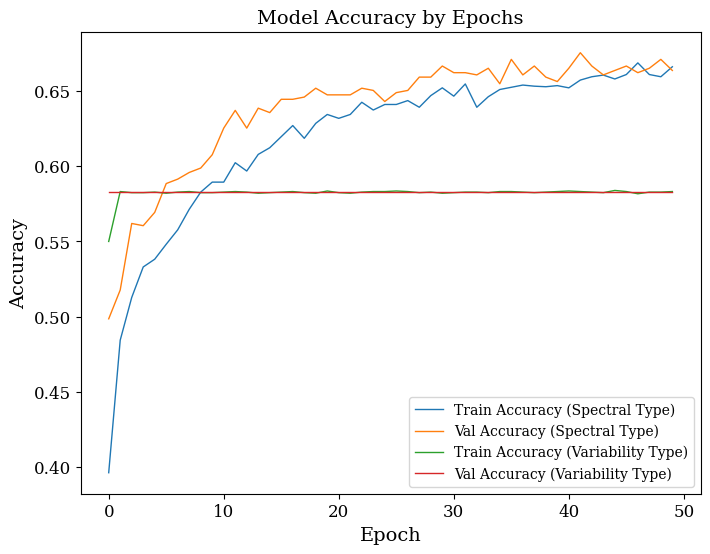

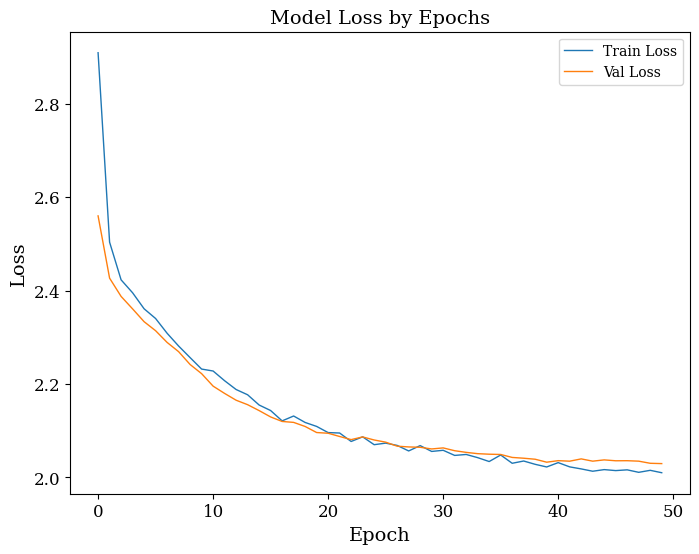

In [586]:
import matplotlib.pyplot as plt

# Построение графиков точности
plt.plot(history.history['spec_output_accuracy'], label='Train Accuracy (Spectral Type)')
plt.plot(history.history['val_spec_output_accuracy'], label='Val Accuracy (Spectral Type)')
plt.plot(history.history['var_output_accuracy'], label='Train Accuracy (Variability Type)')
plt.plot(history.history['val_var_output_accuracy'], label='Val Accuracy (Variability Type)')
plt.title('Model Accuracy by Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Построение графиков потерь
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss by Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.0007 - spec_output_accuracy: 0.3272 - spec_output_loss: 2.0366 - var_output_accuracy: 0.4075 - var_output_loss: 1.6914 - val_loss: 3.8420 - val_spec_output_accuracy: 0.4499 - val_spec_output_loss: 1.5309 - val_var_output_accuracy: 0.5811 - val_var_output_loss: 1.2775
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step - loss: 4.0944 - spec_output_accuracy: 0.4423 - spec_output_loss: 1.8073 - var_output_accuracy: 0.5647 - var_output_loss: 1.2887 - val_loss: 3.6235 - val_spec_output_accuracy: 0.4233 - val_spec_output_loss: 1.5111 - val_var_output_accuracy: 0.5826 - val_var_output_loss: 1.2282
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - loss: 3.8289 - spec_output_accuracy: 0.4308 - spec_output_loss: 1.6916 - var_output_accuracy: 0.5763 - var_output_loss: 1.2730 - val_loss: 3.4436 - val_spec_output_accuracy: 0.4838 - val_spec_output_loss: 1.4304 - val_var_output_accuracy: 0.5811 - val_var_output_loss: 1.2204
Epoch 4/50
8

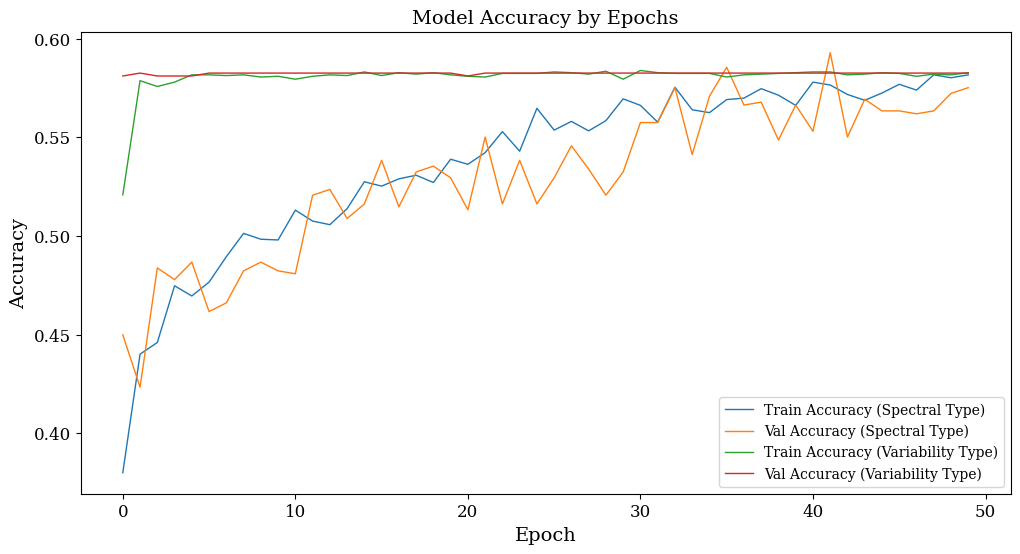

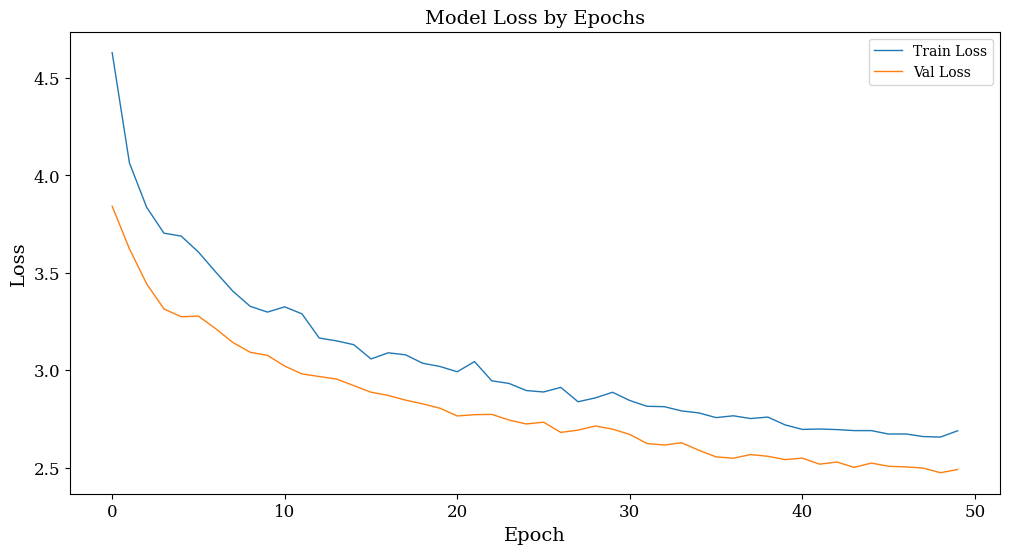

In [590]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.regularizers import l2

# Step 1: Добавляем взаимодействия между признаками
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_spec_filt)
X_test_poly = poly.transform(X_test_spec_filt)

# Step 2: Рассчитываем веса классов
spec_class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_spec_filt),
    y=y_train_spec_filt
)
spec_class_weights = dict(enumerate(spec_class_weights))

var_class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_var_filt),
    y=y_train_var_filt
)
var_class_weights = dict(enumerate(var_class_weights))

# Step 3: Расчет sample weights для каждого выхода
spec_sample_weights = np.array([spec_class_weights[class_id] for class_id in y_train_spec_filt])
var_sample_weights = np.array([var_class_weights[class_id] for class_id in y_train_var_filt])

# Step 4: Создаем нейронную сеть
input_dim = X_train_poly.shape[1]
inputs = Input(shape=(input_dim,))

# Hidden layers с L2-регуляризацией и Dropout
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(inputs)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)

# Output для спектрального типа
output_spec = Dense(len(np.unique(y_train_spec_filt)), activation='softmax', name='spec_output')(x)

# Output для переменности
output_var = Dense(len(np.unique(y_train_var_filt)), activation='softmax', name='var_output')(x)

# Define the model
model = Model(inputs=inputs, outputs=[output_spec, output_var])

# Compile the model
model.compile(
    optimizer='adam',
    loss={'spec_output': 'sparse_categorical_crossentropy', 'var_output': 'sparse_categorical_crossentropy'},
    metrics={'spec_output': 'accuracy', 'var_output': 'accuracy'}
)

# Step 5: Train the model
history = model.fit(
    X_train_poly,
    {'spec_output': y_train_spec_filt, 'var_output': y_train_var_filt},
    validation_data=(X_test_poly, {'spec_output': y_test_spec_filt, 'var_output': y_test_var_filt}),
    epochs=50,
    batch_size=32,
    sample_weight=spec_sample_weights,  # Учет весов классов для спектрального типа
    verbose=1
)

# Step 6: Evaluate the model
results = model.evaluate(X_test_poly, {'spec_output': y_test_spec_filt, 'var_output': y_test_var_filt})
print("Evaluation Results:", results)

# Step 7: Получение отчётов классификации
spec_pred_nn = model.predict(X_test_poly)[0].argmax(axis=1)  # Предсказания спектрального типа
var_pred_nn = model.predict(X_test_poly)[1].argmax(axis=1)  # Предсказания типа переменности

from sklearn.metrics import classification_report
spec_report_nn = classification_report(y_test_spec_filt, spec_pred_nn, target_names=spec_label_encoder_filtered.classes_)
var_report_nn = classification_report(y_test_var_filt, var_pred_nn, target_names=var_label_encoder_filtered.classes_)

print("Spectral Type Classification Report (NN):")
print(spec_report_nn)

print("\nVariability Type Classification Report (NN):")
print(var_report_nn)

# Step 8: Построение графиков
import matplotlib.pyplot as plt

# Построение графиков точности
plt.figure(figsize=(12, 6))
plt.plot(history.history['spec_output_accuracy'], label='Train Accuracy (Spectral Type)')
plt.plot(history.history['val_spec_output_accuracy'], label='Val Accuracy (Spectral Type)')
plt.plot(history.history['var_output_accuracy'], label='Train Accuracy (Variability Type)')
plt.plot(history.history['val_var_output_accuracy'], label='Val Accuracy (Variability Type)')
plt.title('Model Accuracy by Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Построение графиков потерь
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss by Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()
